# Setting up

In [49]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_validate, KFold, train_test_split, cross_val_score
from sklearn.metrics import median_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge


from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from footbot.data.utils import set_up_bigquery, run_query

In [2]:
pd.set_option('max_colwidth', 60)
pd.set_option('max_rows', 200)
pd.set_option('max_columns', 100)

In [3]:
client = set_up_bigquery('../../secrets/service_account.json')

# Getting data

In [4]:
sql = '''
WITH
  element_status AS (
    -- a - available
    -- d - doubtful, i.e. some injury
    -- i - injured, i.e. long term injury - includes return date
    -- n - loaned out of league
    -- s - suspended - includes return date
    -- u - transferred out of league
  SELECT
    season,
    current_event,
    element_all,
    CASE
      WHEN status = 'a' THEN 'available'
      WHEN status = 'd' THEN 'doubtful'
      WHEN status IN ('i', 's') THEN 'unavailable'
      WHEN status IN ('n',
      'u') THEN 'invalid'
  END
    AS status,
    chance_of_playing_next_round / 100 AS availability,
    injury_type,
    CASE
      WHEN PARSE_DATE('%d %b%Y', CONCAT(return_date, EXTRACT(YEAR FROM datetime))) > DATE(datetime) THEN PARSE_DATE('%d %b%Y', CONCAT(return_date, EXTRACT(YEAR FROM datetime)))
    ELSE
    PARSE_DATE('%d %b%Y',
      CONCAT(return_date, EXTRACT(YEAR
        FROM
          datetime) + 1))
  END
    AS return_date,
    is_unknown_return_date,
    transfers_in,
    transfers_out,
  FROM (
    SELECT
      season,
      current_event,
      element_all,
      status,
      CASE
        WHEN status = 'a' THEN 100.0
      ELSE
      chance_of_playing_next_round
    END
      AS chance_of_playing_next_round,
      CASE
        WHEN status IN ('d', 'i') THEN REGEXP_EXTRACT(news, r"(.*?) - ")
    END
      AS injury_type,
      CASE
        WHEN status = 'i' THEN REGEXP_EXTRACT(news, r"Expected back (.*)")
        WHEN status = 's' THEN REGEXP_EXTRACT(news, r"until (.*)")
    END
      AS return_date,
      CASE
        WHEN status = 'i' THEN CAST(REGEXP_CONTAINS(news, r"Unknown return date") AS int64)
        WHEN status = 's' THEN CAST(REGEXP_CONTAINS(news, r"unknown return date") AS int64)
    END
      AS is_unknown_return_date,
      transfers_in,
      transfers_out,
      datetime
    FROM (
      SELECT
        ed.season,
        current_event,
        element_all,
        chance_of_playing_next_round,
        news,
        status,
        transfers_in_event AS transfers_in,
        transfers_out_event AS transfers_out,
        datetime,
        ROW_NUMBER() OVER(PARTITION BY element_all, ed.season, current_event ORDER BY datetime DESC) AS is_most_recent,
      FROM
        `footbot-001.fpl.element_data_all` AS ed
      INNER JOIN
        `footbot-001.fpl.elements_all` AS e
      ON
        ed.element = e.element
        AND ed.season = e.season )
    WHERE
      is_most_recent = 1 ) ),
  ----------------------------------------------------------------------------------------------------------------------------------
  element_gameweeks AS (
  SELECT
    eg.* EXCEPT(transfers_in,
      transfers_out),
    es.* EXCEPT(element_all,
      season),
    e.* EXCEPT(element,
      season),
    DENSE_RANK() OVER(PARTITION BY e.element_all ORDER BY eg.season, event ) AS event_order,
    DENSE_RANK() OVER(ORDER BY eg.season, event ) AS event_order_all_players
  FROM
    `footbot-001.fpl.element_gameweeks_all` AS eg
  INNER JOIN
    `footbot-001.fpl.elements_all` AS e
  ON
    eg.element = e.element
    AND eg.season = e.season
  INNER JOIN
    element_status AS es
  ON
    e.element_all = es.element_all
    AND eg.season = es.season
    AND eg.event = es.current_event + 1 ),
  ----------------------------------------------------------------------------------------------------------------------------------
  historic_form AS (
  SELECT
    DISTINCT element_all,
    event_order,
    -- average minutes, available or otherwise
    AVG(minutes) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 1 PRECEDING AND 1 PRECEDING) AS avg_minutes_p1,
    AVG(minutes) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 2 PRECEDING AND 1 PRECEDING) AS avg_minutes_p2,
    AVG(minutes) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 3 PRECEDING AND 1 PRECEDING) AS avg_minutes_p3,
    AVG(minutes) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 4 PRECEDING AND 1 PRECEDING) AS avg_minutes_p4,
    AVG(minutes) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 5 PRECEDING AND 1 PRECEDING) AS avg_minutes_p5,
    AVG(minutes) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 10 PRECEDING AND 1 PRECEDING) AS avg_minutes_p10,
    -- average available minutes
    AVG(
    IF
      (status = 'available',
        minutes,
        NULL)) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 1 PRECEDING AND 1 PRECEDING) AS avg_available_minutes_p1,
    AVG(
    IF
      (status = 'available',
        minutes,
        NULL)) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 2 PRECEDING AND 1 PRECEDING) AS avg_available_minutes_p2,
    AVG(
    IF
      (status = 'available',
        minutes,
        NULL)) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 3 PRECEDING AND 1 PRECEDING) AS avg_available_minutes_p3,
    AVG(
    IF
      (status = 'available',
        minutes,
        NULL)) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 4 PRECEDING AND 1 PRECEDING) AS avg_available_minutes_p4,
    AVG(
    IF
      (status = 'available',
        minutes,
        NULL)) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 5 PRECEDING AND 1 PRECEDING) AS avg_available_minutes_p5,
    AVG(
    IF
      (status = 'available',
        minutes,
        NULL)) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 10 PRECEDING AND 1 PRECEDING) AS avg_available_minutes_p10,
    AVG(
    IF
      (status = 'available',
        minutes,
        NULL)) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 20 PRECEDING AND 1 PRECEDING) AS avg_available_minutes_p20,
    AVG(
    IF
      (status = 'available',
        minutes,
        NULL)) OVER(PARTITION BY element_all ORDER BY event_order RANGE BETWEEN 30 PRECEDING AND 1 PRECEDING) AS avg_available_minutes_p30,
    -- average available minutes across all players
    AVG(
    IF
      (status = 'available',
        minutes,
        NULL)) OVER(ORDER BY event_order_all_players RANGE BETWEEN 3 PRECEDING AND 1 PRECEDING) AS avg_available_minutes_all_players_p3,
  FROM
    element_gameweeks ),
  ----------------------------------------------------------------------------------------------------------------------------------
  injury_type_minutes AS (
  SELECT
    injury_type,
    event_order_all_players,
    total_minutes / num_instances AS avg_injury_type_minutes
  FROM (
    SELECT
      injury_type,
      event_order_all_players,
      SUM(total_minutes) OVER(PARTITION BY injury_type ORDER BY event_order_all_players RANGE BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) AS total_minutes,
      SUM(num_instances) OVER(PARTITION BY injury_type ORDER BY event_order_all_players RANGE BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) AS num_instances
    FROM (
      SELECT
        injury_type,
        event_order_all_players,
        SUM(minutes) AS total_minutes,
        COUNT(minutes) AS num_instances
      FROM
        element_gameweeks
      WHERE
        injury_type IS NOT NULL
      GROUP BY
        1,
        2 ))),
  ----------------------------------------------------------------------------------------------------------------------------------
  return_from_injury AS (
  SELECT
    element_all,
    event_order,
    TIMESTAMP_DIFF(kickoff_time, most_recent_returned_from_injury_kickoff_time, day) AS days_since_returned_from_injury
  FROM (
    SELECT
      *,
      MAX(returned_from_injury_kickoff_time) OVER(PARTITION BY element_all ORDER BY event_order) AS most_recent_returned_from_injury_kickoff_time
    FROM (
      SELECT
        element_all,
        event_order,
        kickoff_time,
      IF
        (status = 'available'
          AND previous_event_injury_type IS NOT NULL,
          kickoff_time,
          NULL) AS returned_from_injury_kickoff_time
      FROM (
        SELECT
          element_all,
          event_order,
          status,
          MIN(kickoff_time) AS kickoff_time,
          MIN(previous_event_injury_type) AS previous_event_injury_type
        FROM (
          SELECT
            element_all,
            event_order,
            kickoff_time,
            status,
            LAG(injury_type) OVER(PARTITION BY element_all ORDER BY event_order) AS previous_event_injury_type,
          FROM
            element_gameweeks )
        GROUP BY
          1,
          2,
          3 ))) )
  ----------------------------------------------------------------------------------------------------------------------------------
  ----------------------------------------------------------------------------------------------------------------------------------
  ----------------------------------------------------------------------------------------------------------------------------------
  -- 23563
SELECT
  -- meta
  eg.element_all,
  safe_web_name,
  eg.event,
  eg.kickoff_time,
  -- target
  minutes,
  -- element information
  eg.safe_team_name AS team,
  CAST(eg.element_type AS STRING)AS element_type,
  value,
  -- injury information
  status,
  availability,
  eg.injury_type,
  im.avg_injury_type_minutes,
  COALESCE(SAFE_DIVIDE(im.avg_injury_type_minutes * avg_available_minutes_p3,
      avg_available_minutes_all_players_p3),
    0) AS estimated_injury_type_minutes,
  CAST(is_unknown_return_date AS STRING) AS is_unknown_return_date,
  DATE_DIFF(return_date, DATE(eg.kickoff_time), DAY) AS days_until_return,
  days_since_returned_from_injury,
  -- transfers
  transfers_in,
  transfers_out,
  transfers_in - transfers_out AS net_transfers_in,
  -- average minutes, available or otherwise
  avg_minutes_p1,
  avg_minutes_p2,
  avg_minutes_p3,
  avg_minutes_p4,
  avg_minutes_p5,
  avg_minutes_p10,
  -- average available minutes
  avg_available_minutes_p1,
  avg_available_minutes_p2,
  avg_available_minutes_p3,
  avg_available_minutes_p4,
  avg_available_minutes_p5,
  avg_available_minutes_p10,
  -- average available minutes across all players
  avg_available_minutes_all_players_p3,
  -- estimated minutes
  CASE
    WHEN status = 'available' THEN COALESCE(avg_available_minutes_p3, avg_available_minutes_all_players_p3)
    WHEN status = 'doubtful' THEN COALESCE(SAFE_DIVIDE(im.avg_injury_type_minutes * avg_available_minutes_p3,
      avg_available_minutes_all_players_p3),
    0)
    WHEN status = 'unavailable' THEN 0
END
  AS estimated_minutes
FROM
  element_gameweeks AS eg
INNER JOIN
  historic_form AS hf
ON
  eg.element_all = hf.element_all
  AND eg.event_order = hf.event_order
LEFT JOIN
  injury_type_minutes AS im
ON
  eg.injury_type = im.injury_type
  AND eg.event_order_all_players = im.event_order_all_players
INNER JOIN
  return_from_injury AS ri
ON
  eg.element_all = ri.element_all
  AND eg.event_order = ri.event_order
WHERE
  ((eg.event >= 4
      AND eg.season = '1920')
    OR eg.season >= '2021') -- status data missing for previous events
  AND status != 'invalid'
'''

In [5]:
df = run_query(sql, client)
df = df.fillna(np.nan)
df.sample(10)

,element_all,safe_web_name,event,kickoff_time,minutes,team,element_type,value,status,availability,injury_type,avg_injury_type_minutes,estimated_injury_type_minutes,is_unknown_return_date,days_until_return,days_since_returned_from_injury,transfers_in,transfers_out,net_transfers_in,avg_minutes_p1,avg_minutes_p2,avg_minutes_p3,avg_minutes_p4,avg_minutes_p5,avg_minutes_p10,avg_available_minutes_p1,avg_available_minutes_p2,avg_available_minutes_p3,avg_available_minutes_p4,avg_available_minutes_p5,avg_available_minutes_p10,avg_available_minutes_all_players_p3,estimated_minutes
7132,105,anguissa,4,2020-10-04 13:00:00+00:00,90,fulham,3,45,available,1.00,NaN,NaN,0.000000,NaN,NaN,NaN,26006,19960,6046,90.0,90.0,69.000000,69.00,69.000000,69.000000,90.0,90.0,69.000000,69.00,69.000000,69.000000,44.581070,69.000000
18593,178,leno,6,2019-09-22 15:30:00+00:00,90,arsenal,1,50,available,1.00,NaN,NaN,0.000000,NaN,NaN,NaN,15429,15908,-479,90.0,90.0,90.000000,90.00,90.000000,90.000000,90.0,90.0,90.000000,90.00,90.000000,90.000000,47.187500,90.000000
1559,1014,batshuayi,13,2019-11-23 17:30:00+00:00,17,chelsea,4,66,available,1.00,NaN,NaN,0.000000,NaN,NaN,NaN,1873,2086,-213,17.0,9.5,6.333333,4.75,5.000000,7.111111,17.0,9.5,6.333333,4.75,5.000000,7.111111,44.693396,6.333333
20165,993,aarons,20,2019-12-28 17:30:00+00:00,90,norwich,2,44,doubtful,0.75,Knock,38.129870,76.968801,NaN,NaN,84.0,383,1345,-962,90.0,90.0,90.000000,90.00,90.000000,90.000000,90.0,90.0,90.000000,90.00,90.000000,90.000000,44.585446,76.968801
1657,1008,obafemi,14,2019-11-30 17:30:00+00:00,56,southampton,4,49,available,1.00,NaN,NaN,0.000000,NaN,NaN,77.0,840,319,521,75.0,38.0,25.333333,19.00,15.200000,10.000000,75.0,38.0,25.333333,19.00,15.200000,11.111111,45.074250,25.333333
2817,757,jota,21,2020-01-01 12:30:00+00:00,0,aston villa,3,58,available,1.00,NaN,NaN,0.000000,NaN,NaN,23.0,170,298,-128,45.0,25.5,17.000000,12.75,10.200000,6.500000,45.0,25.5,17.000000,12.75,10.200000,10.200000,44.384553,17.000000
19567,430,capoue,15,2019-12-04 19:30:00+00:00,90,watford,3,48,available,1.00,NaN,NaN,0.000000,NaN,NaN,25.0,197,254,-57,90.0,90.0,90.000000,67.50,54.000000,54.000000,90.0,90.0,90.000000,90.00,90.000000,75.000000,45.168646,90.000000
22182,940,dubravka,2,2020-09-20 13:00:00+00:00,0,newcastle,1,50,unavailable,0.00,Heel Injury,1.052632,2.207498,1,NaN,NaN,264,5868,-5604,0.0,45.0,60.000000,67.50,72.000000,81.000000,NaN,90.0,90.000000,90.00,90.000000,90.000000,42.915940,0.000000
21961,969,targett,47,2020-07-26 15:00:00+00:00,90,aston villa,2,43,available,1.00,NaN,NaN,0.000000,NaN,NaN,9.0,5062,1685,3377,90.0,90.0,77.666667,58.25,46.600000,63.000000,90.0,90.0,90.000000,90.00,90.000000,80.000000,42.608728,90.000000
21640,414,martinez,43,2020-07-07 19:15:00+00:00,90,arsenal,1,43,available,1.00,NaN,NaN,0.000000,NaN,NaN,NaN,17149,2148,15001,90.0,90.0,90.000000,64.00,45.714286,26.666667,90.0,90.0,90.000000,64.00,45.714286,26.666667,42.057706,90.000000


# Profile data

In [115]:
profile_df = df.copy()

## Minutes

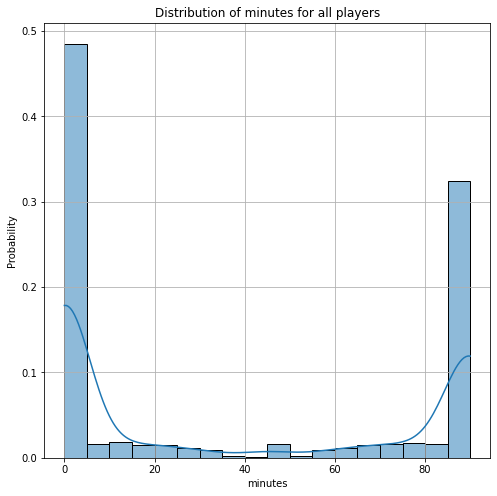

In [7]:
plt.figure(figsize=(8,8))
sns.histplot(
    data=profile_df,
    x='minutes',
    binwidth=5,
    kde=True,
    stat='probability'
)
plt.title('Distribution of minutes for all players')
plt.grid()
plt.show()

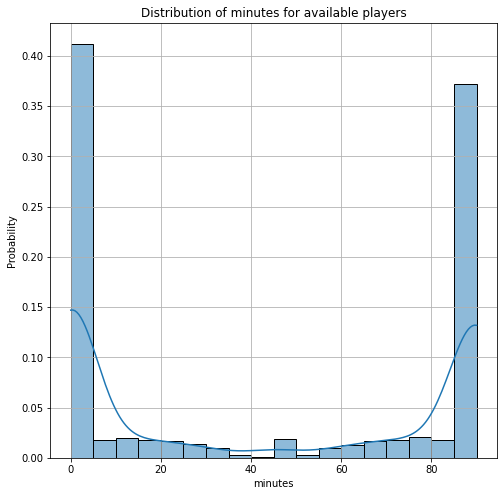

In [11]:
plt.figure(figsize=(8,8))
sns.histplot(
    data=profile_df[profile_df['status'] == 'available'],
    x='minutes',
    binwidth=5,
    kde=True,
    stat='probability'
)
plt.title('Distribution of minutes for available players')
plt.grid()
plt.show()

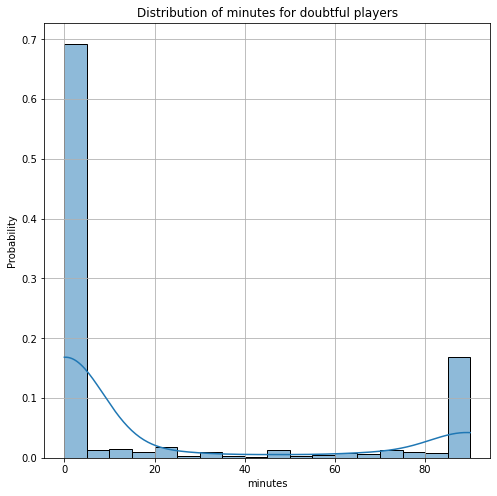

In [12]:
plt.figure(figsize=(8,8))
sns.histplot(
    data=profile_df[profile_df['status'] == 'doubtful'],
    x='minutes',
    binwidth=5,
    kde=True,
    stat='probability'
)
plt.title('Distribution of minutes for doubtful players')
plt.grid()
plt.show()

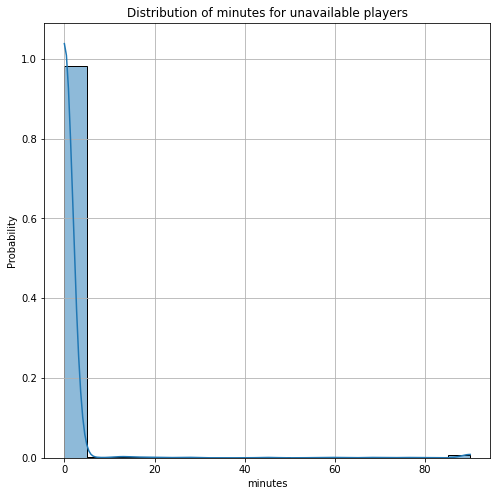

In [9]:
plt.figure(figsize=(8,8))
sns.histplot(
    data=profile_df[profile_df['status'] == 'unavailable'],
    x='minutes',
    binwidth=5,
    kde=True,
    stat='probability'
)
plt.title('Distribution of minutes for unavailable players')
plt.grid()
plt.show()

## Availability

In [13]:
profile_df['played'] = profile_df['minutes'].apply(lambda x: 1.0 if x > 0 else 0)
profile_df['played_majority'] = profile_df['minutes'].apply(lambda x: 1.0 if x > 60 else 0)

In [14]:
profile_df['availability'].unique()

array([0.75, 1.  , 0.  , 0.25, 0.5 ])

In [15]:
profile_df[profile_df['availability'] == 0]['played'].describe(np.linspace(0.1, 0.9, 9))

count    2396.000000
mean        0.020033
std         0.140144
min         0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
max         1.000000
Name: played, dtype: float64

In [16]:
profile_df[profile_df['availability'] == 0.75]['played'].describe(np.linspace(0.1, 0.9, 9))

count    831.000000
mean       0.427196
std        0.494969
min        0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%        0.000000
60%        1.000000
70%        1.000000
80%        1.000000
90%        1.000000
max        1.000000
Name: played, dtype: float64

In [17]:
# for regular starters
profile_df[
    profile_df['avg_available_minutes_p10'] >= 60
].groupby('availability')['played_majority'].mean()

availability
0.00    0.014225
0.25    0.107692
0.50    0.162500
0.75    0.488304
1.00    0.806443
Name: played_majority, dtype: float64

## Injury type

In [109]:
profile_df.groupby('injury_type')['minutes'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
injury_type,,,,,,,,
Concussion,2.0,45.000000,63.639610,0.0,22.5,45.0,67.50,90.0
Dead leg,10.0,40.100000,40.366240,0.0,0.0,34.5,83.00,90.0
Facial Injury,3.0,34.333333,48.644972,0.0,6.5,13.0,51.50,90.0
Knock,226.0,24.455752,37.952605,0.0,0.0,0.0,63.50,90.0
Head injury,22.0,23.090909,39.117538,0.0,0.0,0.0,43.50,90.0
Personal Reasons,10.0,22.500000,38.242646,0.0,0.0,0.0,33.75,90.0
Wrist Injury,4.0,22.500000,45.000000,0.0,0.0,0.0,22.50,90.0
Eye Injury,1.0,21.000000,NaN,21.0,21.0,21.0,21.00,21.0
Illness,96.0,18.989583,35.509375,0.0,0.0,0.0,5.00,90.0


In [113]:
profile_df.groupby(['injury_type', 'element_type'])['minutes'].describe()

count       mean        std   min  \
injury_type                element_type                                      
Abdominal injury           2               2.0  45.000000  63.639610   0.0   
                           3              10.0   0.000000   0.000000   0.0   
                           4              31.0   0.000000   0.000000   0.0   
Achilles injury            1              16.0   0.000000   0.000000   0.0   
                           2              10.0   9.000000  28.460499   0.0   
                           3              69.0   1.014493   8.427010   0.0   
                           4              12.0   7.500000  25.980762   0.0   
Ankle injury               1               6.0   0.000000   0.000000   0.0   
                           2             144.0  10.826389  28.838671   0.0   
                           3             182.0   9.401099  25.995933   0.0   
                           4              20.0  16.000000  31.614454   0.0   
Anterior cruciate ligament 2               7.0   0.000000   0.000000   0.0   
Arm injury                 1              16.0   5.625000  22.500000   0.0   
                           3               3.0   0.000000   0.000000   0.0   
                           4               5.0   5.600000  12.521981   0.0   
Back injury                1               3.0   0.000000   0.000000   0.0   
                           2              22.0  24.545455  41.025808   0.0   
                           3              42.0  10.690476  28.223402   0.0   
                           4               8.0   0.000000   0.000000   0.0   
Calf injury                1              14.0   6.428571  24.053512   0.0   
                           2              50.0   7.340000  24.637461   0.0   
                           3              66.0  11.909091  27.882019   0.0   
                           4              12.0  25.250000  38.160248   0.0   
Concussion                 2               1.0  90.000000        NaN  90.0   
                           3               1.0   0.000000        NaN   0.0   
Dead leg                   2               2.0  90.000000   0.000000  90.0   
                           3               7.0  31.571429  35.514585   0.0   
                           4               1.0   0.000000        NaN   0.0   
Eye Injury                 2               1.0  21.000000        NaN  21.0   
Facial Injury              2               2.0   6.500000   9.192388   0.0   
                           3               1.0  90.000000        NaN  90.0   
Fatigue                    2               4.0  16.000000  32.000000   0.0   
Foot injury                2              33.0   5.454545  21.807526   0.0   
                           3              17.0   3.764706  15.522280   0.0   
                           4               6.0  15.000000  36.742346   0.0   
Glute injury               4               1.0   0.000000        NaN   0.0   
Groin Injury               1               8.0  25.125000  40.692005   0.0   
                           2              77.0   7.532468  24.324335   0.0   
                           3              82.0   5.195122  18.992812   0.0   
                           4              35.0  14.742857  32.003072   0.0   
Hamstring injury           1               2.0  45.000000  63.639610   0.0   
                           2             213.0  10.629108  28.571303   0.0   
                           3             196.0   9.698980  25.395461   0.0   
                           4              74.0   7.270270  21.488638   0.0   
Hand injury                2               3.0   0.000000   0.000000   0.0   
                           4               1.0   5.000000        NaN   5.0   
Head injury                1               1.0   0.000000        NaN   0.0   
                           2              16.0  31.750000  43.000000   0.0   
                           3               1.0   0.000000        NaN   0.0   
                           4               4.0   0.000000   0.0

## Return from injury

In [118]:
profile_df['days_since_returned_from_injury'].describe()

count    10518.000000
mean        94.746054
std         96.118025
min          0.000000
25%         19.000000
50%         59.000000
75%        149.000000
max        443.000000
Name: days_since_returned_from_injury, dtype: float64

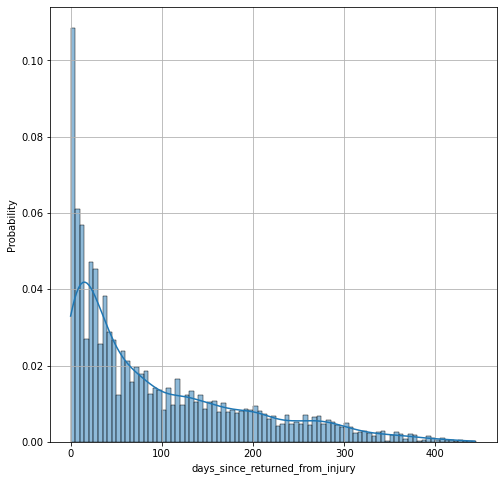

In [119]:
plt.figure(figsize=(8,8))
sns.histplot(
    data=profile_df,
    x='days_since_returned_from_injury',
    binwidth=5,
    kde=True,
    stat='probability'
)
plt.grid()
plt.show()

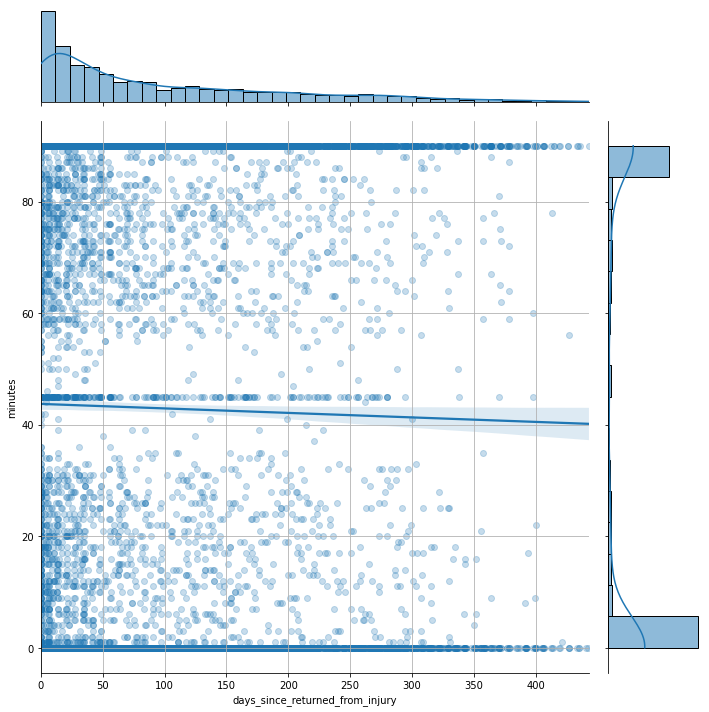

In [120]:
sns.jointplot(
    x='days_since_returned_from_injury',
    y='minutes',
    data=profile_df,
    kind='reg',
    height=10,
    joint_kws = {'scatter_kws':dict(alpha=0.25)}
)
plt.grid()
plt.show()

## Average minutes

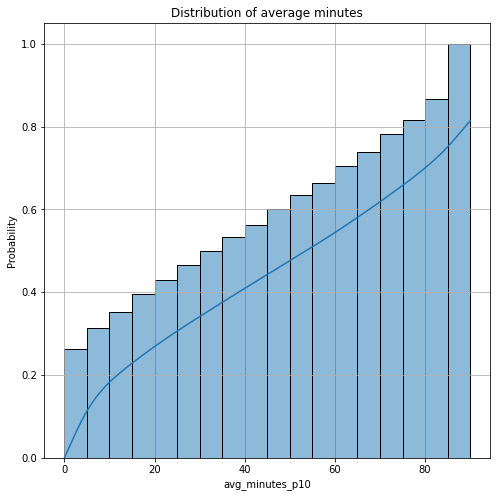

In [25]:
plt.figure(figsize=(8,8))
sns.histplot(
    data=profile_df,
    x='avg_minutes_p10',
    binwidth=5,
    kde=True,
    stat='probability',
    cumulative=True
)
plt.title('Distribution of average minutes')
plt.grid()
plt.show()

In [26]:
avg_min_cols = [
    'avg_minutes_p30',
    'avg_minutes_p20',
    'avg_minutes_p15',
    'avg_minutes_p10',
    'avg_minutes_p5',
    'avg_minutes_p4',
    'avg_minutes_p3',
    'avg_minutes_p2',
    'avg_minutes_p1',
    'minutes'
]

avg_min_corr = profile_df[
    profile_df['status'] == 'available'
][avg_min_cols].corr()

avg_min_corr

,avg_minutes_p30,avg_minutes_p20,avg_minutes_p15,avg_minutes_p10,avg_minutes_p5,avg_minutes_p4,avg_minutes_p3,avg_minutes_p2,avg_minutes_p1,minutes
avg_minutes_p30,1.000000,0.988990,0.972507,0.943160,0.883180,0.862639,0.836283,0.798672,0.732710,0.662429
avg_minutes_p20,0.988990,1.000000,0.989715,0.961636,0.899325,0.877733,0.850010,0.810928,0.743075,0.668846
avg_minutes_p15,0.972507,0.989715,1.000000,0.979924,0.917622,0.895134,0.866089,0.825232,0.754998,0.675368
avg_minutes_p10,0.943160,0.961636,0.979924,1.000000,0.948651,0.925619,0.895422,0.852125,0.778232,0.686811
avg_minutes_p5,0.883180,0.899325,0.917622,0.948651,1.000000,0.987683,0.960584,0.914723,0.831756,0.703503
avg_minutes_p4,0.862639,0.877733,0.895134,0.925619,0.987683,1.000000,0.981191,0.937867,0.852748,0.709028
avg_minutes_p3,0.836283,0.850010,0.866089,0.895422,0.960584,0.981191,1.000000,0.967404,0.882130,0.713169
avg_minutes_p2,0.798672,0.810928,0.825232,0.852125,0.914723,0.937867,0.967404,1.000000,0.925993,0.715514
avg_minutes_p1,0.732710,0.743075,0.754998,0.778232,0.831756,0.852748,0.882130,0.925993,1.000000,0.702034
minutes,0.662429,0.668846,0.675368,0.686811,0.703503,0.709028,0.713169,0.715514,0.702034,1.000000


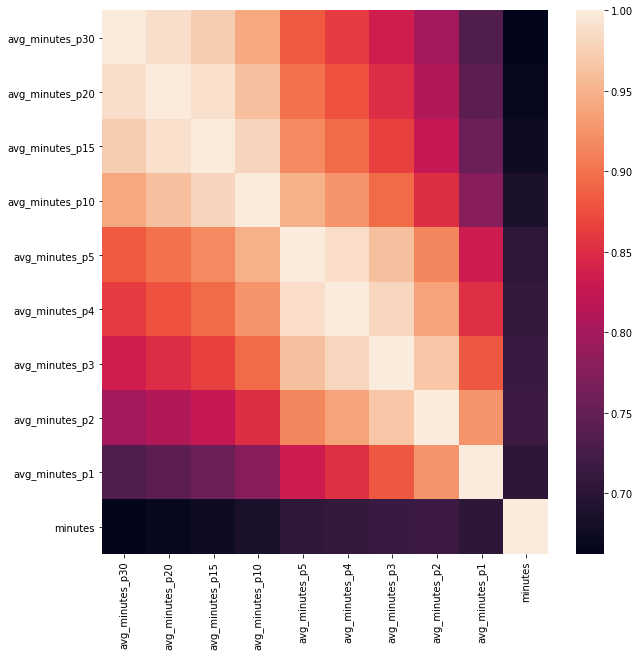

In [27]:
plt.figure(figsize=(10,10))
sns.heatmap(
    avg_min_corr, 
)
plt.show()

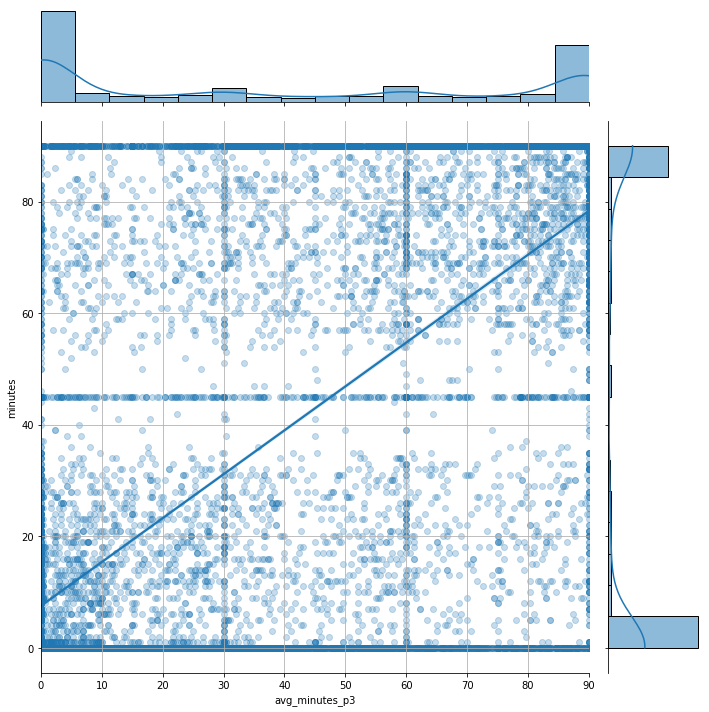

In [28]:
sns.jointplot(
    x='avg_minutes_p3',
    y='minutes',
    data=profile_df,
    kind='reg',
    height=10,
    joint_kws = {'scatter_kws':dict(alpha=0.25)}
)
plt.grid()
plt.show()

## Average available minutes

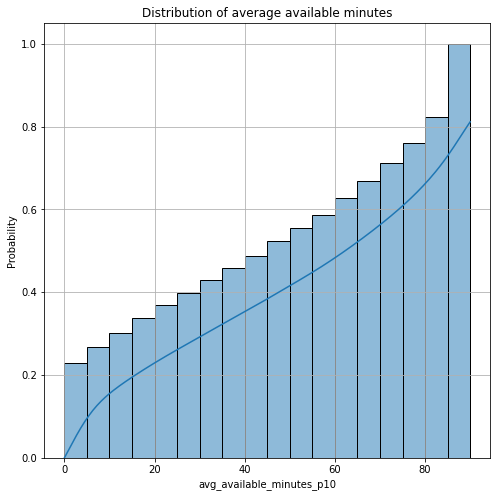

In [19]:
plt.figure(figsize=(8,8))
sns.histplot(
    data=profile_df,
    x='avg_available_minutes_p10',
    binwidth=5,
    kde=True,
    stat='probability',
    cumulative=True
)
plt.title('Distribution of average available minutes')
plt.grid()
plt.show()

In [24]:
avg_available_min_cols = [
    'avg_available_minutes_p30',
    'avg_available_minutes_p20',
    'avg_available_minutes_p15',
    'avg_available_minutes_p10',
    'avg_available_minutes_p5',
    'avg_available_minutes_p4',
    'avg_available_minutes_p3',
    'avg_available_minutes_p2',
    'avg_available_minutes_p1',
    'minutes'
]

avg_available_min_corr = profile_df[
    profile_df['status'] == 'available'
][avg_available_min_cols].corr()

avg_available_min_corr

,avg_available_minutes_p30,avg_available_minutes_p20,avg_available_minutes_p15,avg_available_minutes_p10,avg_available_minutes_p5,avg_available_minutes_p4,avg_available_minutes_p3,avg_available_minutes_p2,avg_available_minutes_p1,minutes
avg_available_minutes_p30,1.000000,0.989951,0.975335,0.949223,0.897463,0.879449,0.856792,0.824168,0.770809,0.681420
avg_available_minutes_p20,0.989951,1.000000,0.990226,0.965970,0.913964,0.895157,0.871867,0.838463,0.783576,0.690082
avg_available_minutes_p15,0.975335,0.990226,1.000000,0.981273,0.930522,0.911275,0.887094,0.852504,0.795758,0.697160
avg_available_minutes_p10,0.949223,0.965970,0.981273,1.000000,0.955264,0.935409,0.910521,0.874525,0.815743,0.706786
avg_available_minutes_p5,0.897463,0.913964,0.930522,0.955264,1.000000,0.987143,0.963725,0.925744,0.860936,0.719908
avg_available_minutes_p4,0.879449,0.895157,0.911275,0.935409,0.987143,1.000000,0.981137,0.944595,0.878354,0.723716
avg_available_minutes_p3,0.856792,0.871867,0.887094,0.910521,0.963725,0.981137,1.000000,0.969392,0.902182,0.726403
avg_available_minutes_p2,0.824168,0.838463,0.852504,0.874525,0.925744,0.944595,0.969392,1.000000,0.937772,0.726754
avg_available_minutes_p1,0.770809,0.783576,0.795758,0.815743,0.860936,0.878354,0.902182,0.937772,1.000000,0.716990
minutes,0.681420,0.690082,0.697160,0.706786,0.719908,0.723716,0.726403,0.726754,0.716990,1.000000


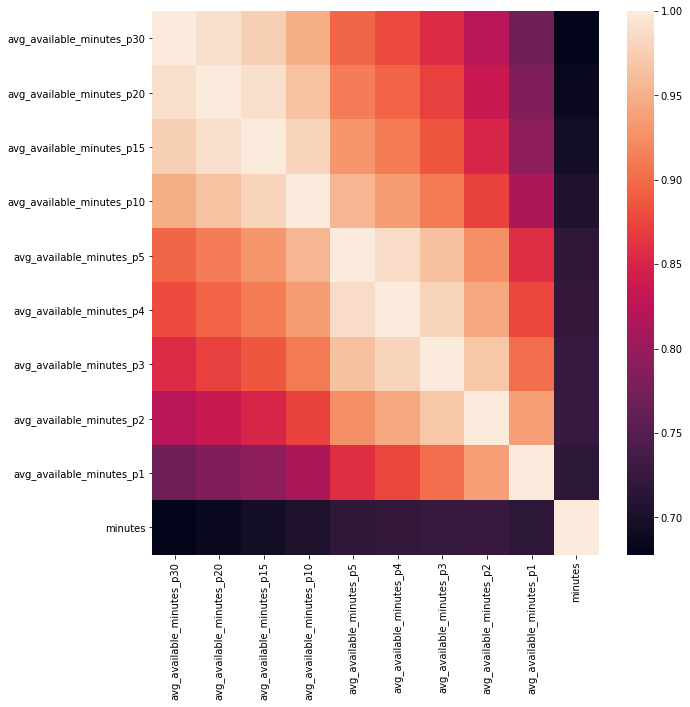

In [30]:
plt.figure(figsize=(10,10))
sns.heatmap(
    avg_available_min_corr, 
)
plt.show()

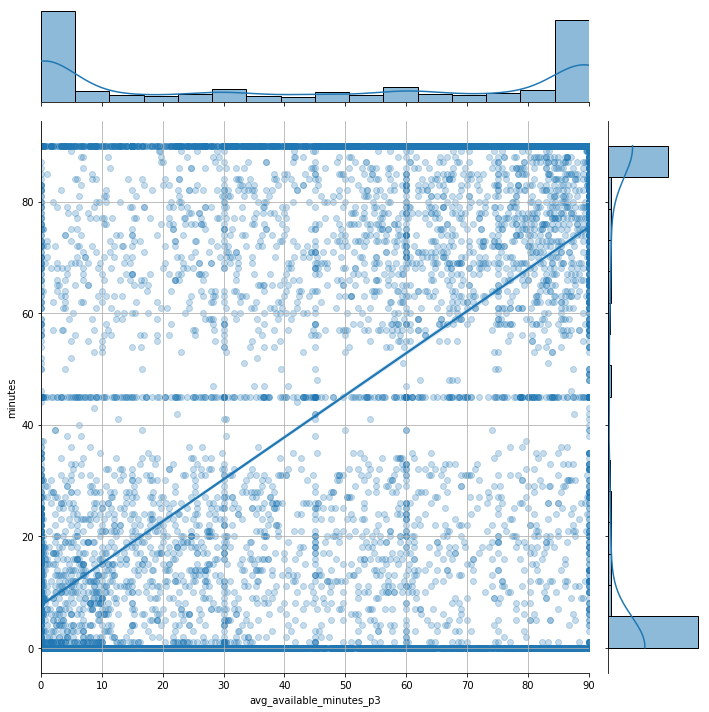

In [24]:
sns.jointplot(
    x='avg_available_minutes_p3',
    y='minutes',
    data=profile_df,
    kind='reg',
    height=10,
    joint_kws = {'scatter_kws':dict(alpha=0.25)}
)
plt.grid()
plt.show()

## Average selected minutes

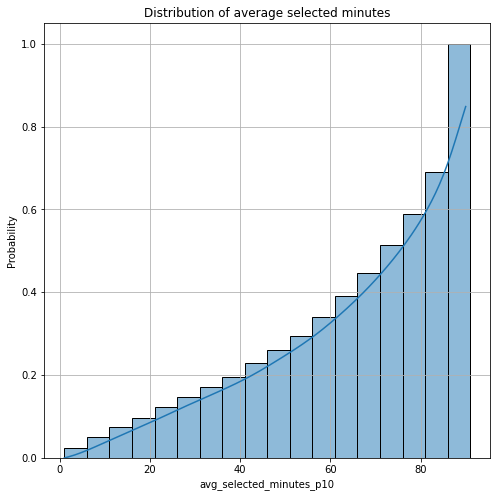

In [18]:
plt.figure(figsize=(8,8))
sns.histplot(
    data=profile_df,
    x='avg_selected_minutes_p10',
    binwidth=5,
    kde=True,
    stat='probability',
    cumulative=True
)
plt.title('Distribution of average selected minutes')
plt.grid()
plt.show()

In [20]:
avg_selected_min_cols = [
    'avg_selected_minutes_p30',
    'avg_selected_minutes_p20',
    'avg_selected_minutes_p15',
    'avg_selected_minutes_p10',
    'avg_selected_minutes_p5',
    'avg_selected_minutes_p4',
    'avg_selected_minutes_p3',
    'avg_selected_minutes_p2',
    'avg_selected_minutes_p1',
    'minutes'
]

avg_selected_min_corr = profile_df[
    profile_df['minutes'] > 0
][avg_selected_min_cols].corr()

avg_selected_min_corr

,avg_selected_minutes_p30,avg_selected_minutes_p20,avg_selected_minutes_p15,avg_selected_minutes_p10,avg_selected_minutes_p5,avg_selected_minutes_p4,avg_selected_minutes_p3,avg_selected_minutes_p2,avg_selected_minutes_p1,minutes
avg_selected_minutes_p30,1.000000,0.984137,0.963507,0.923735,0.845205,0.817246,0.783606,0.739382,0.664425,0.525543
avg_selected_minutes_p20,0.984137,1.000000,0.983567,0.944081,0.864352,0.835073,0.800204,0.753602,0.676010,0.529713
avg_selected_minutes_p15,0.963507,0.983567,1.000000,0.966536,0.885891,0.856233,0.821048,0.773167,0.692463,0.536555
avg_selected_minutes_p10,0.923735,0.944081,0.966536,1.000000,0.923969,0.894481,0.857548,0.807872,0.724086,0.541906
avg_selected_minutes_p5,0.845205,0.864352,0.885891,0.923969,1.000000,0.972480,0.935482,0.880245,0.789045,0.541785
avg_selected_minutes_p4,0.817246,0.835073,0.856233,0.894481,0.972480,1.000000,0.964253,0.908489,0.815401,0.538994
avg_selected_minutes_p3,0.783606,0.800204,0.821048,0.857548,0.935482,0.964253,1.000000,0.945949,0.851435,0.539341
avg_selected_minutes_p2,0.739382,0.753602,0.773167,0.807872,0.880245,0.908489,0.945949,1.000000,0.903991,0.526071
avg_selected_minutes_p1,0.664425,0.676010,0.692463,0.724086,0.789045,0.815401,0.851435,0.903991,1.000000,0.499339
minutes,0.525543,0.529713,0.536555,0.541906,0.541785,0.538994,0.539341,0.526071,0.499339,1.000000


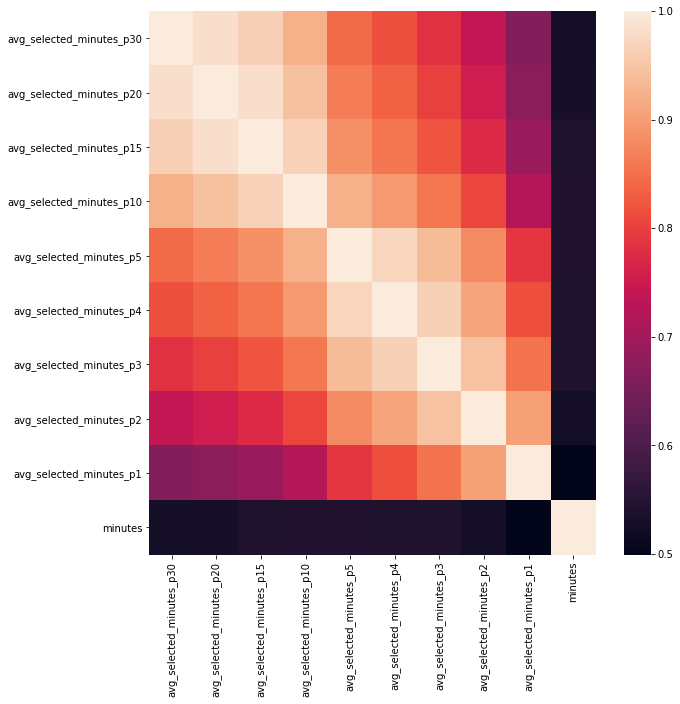

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(
    avg_selected_min_corr, 
)
plt.show()

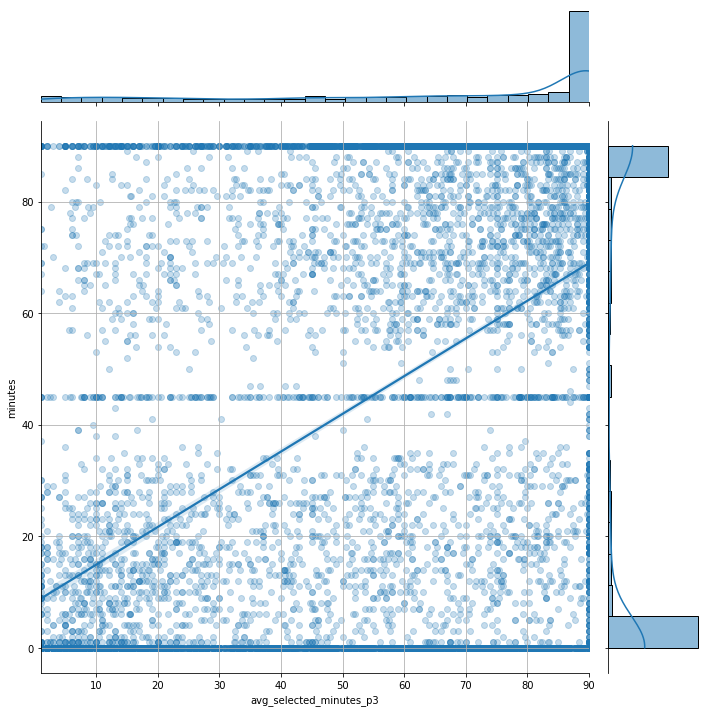

In [22]:
sns.jointplot(
    x='avg_selected_minutes_p3',
    y='minutes',
    data=profile_df,
    kind='reg',
    height=10,
    joint_kws = {'scatter_kws':dict(alpha=0.25)}
)
plt.grid()
plt.show()

## Lagged minutes

In [31]:
lagged_min_cols = [
    'lagged_minutes_p10',
    'lagged_minutes_p9',
    'lagged_minutes_p8',
    'lagged_minutes_p7',
    'lagged_minutes_p6',
    'lagged_minutes_p5',
    'lagged_minutes_p4',
    'lagged_minutes_p3',
    'lagged_minutes_p2',
    'lagged_minutes_p1',
    'minutes'
]

lagged_min_corr = profile_df[
    profile_df['status'] == 'available'
][lagged_min_cols].corr()

lagged_min_corr

,lagged_minutes_p10,lagged_minutes_p9,lagged_minutes_p8,lagged_minutes_p7,lagged_minutes_p6,lagged_minutes_p5,lagged_minutes_p4,lagged_minutes_p3,lagged_minutes_p2,lagged_minutes_p1,minutes
lagged_minutes_p10,1.000000,0.693020,0.599048,0.543648,0.509388,0.480950,0.465866,0.461433,0.448617,0.453223,0.432374
lagged_minutes_p9,0.693020,1.000000,0.695888,0.601262,0.544054,0.510945,0.479670,0.466917,0.461846,0.456154,0.447466
lagged_minutes_p8,0.599048,0.695888,1.000000,0.699740,0.602779,0.547935,0.511886,0.484564,0.470550,0.472110,0.458930
lagged_minutes_p7,0.543648,0.601262,0.699740,1.000000,0.700563,0.606920,0.552159,0.518192,0.491567,0.484475,0.473601
lagged_minutes_p6,0.509388,0.544054,0.602779,0.700563,1.000000,0.698862,0.605636,0.555777,0.523907,0.504311,0.485458
lagged_minutes_p5,0.480950,0.510945,0.547935,0.606920,0.698862,1.000000,0.698277,0.608174,0.558601,0.535832,0.504269
lagged_minutes_p4,0.465866,0.479670,0.511886,0.552159,0.605636,0.698277,1.000000,0.700253,0.609774,0.570181,0.534968
lagged_minutes_p3,0.461433,0.466917,0.484564,0.518192,0.555777,0.608174,0.700253,1.000000,0.699199,0.620675,0.567468
lagged_minutes_p2,0.448617,0.461846,0.470550,0.491567,0.523907,0.558601,0.609774,0.699199,1.000000,0.704903,0.617725
lagged_minutes_p1,0.453223,0.456154,0.472110,0.484475,0.504311,0.535832,0.570181,0.620675,0.704903,1.000000,0.702034


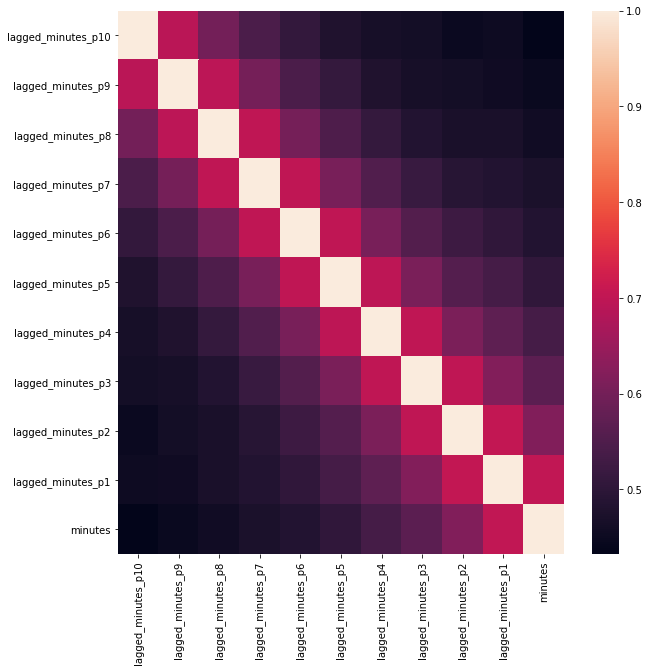

In [32]:
plt.figure(figsize=(10,10))
sns.heatmap(
    lagged_min_corr, 
)
plt.show()

## Pecking order

In [49]:
pecking_order_cols = [
    'pecking_order_selection',
    'pecking_order_value',
    'pecking_order_selection_capped',
    'pecking_order_value_capped',
    'minutes'
]

pecking_order_corr = profile_df[
    profile_df['status'] == 'available'
][pecking_order_cols].corr()

pecking_order_corr

,pecking_order_selection,pecking_order_value,pecking_order_selection_capped,pecking_order_value_capped,minutes
pecking_order_selection,1.000000,0.559555,0.800923,0.460797,-0.537476
pecking_order_value,0.559555,1.000000,0.479397,0.805530,-0.399045
pecking_order_selection_capped,0.800923,0.479397,1.000000,0.575723,-0.399617
pecking_order_value_capped,0.460797,0.805530,0.575723,1.000000,-0.292196
minutes,-0.537476,-0.399045,-0.399617,-0.292196,1.000000


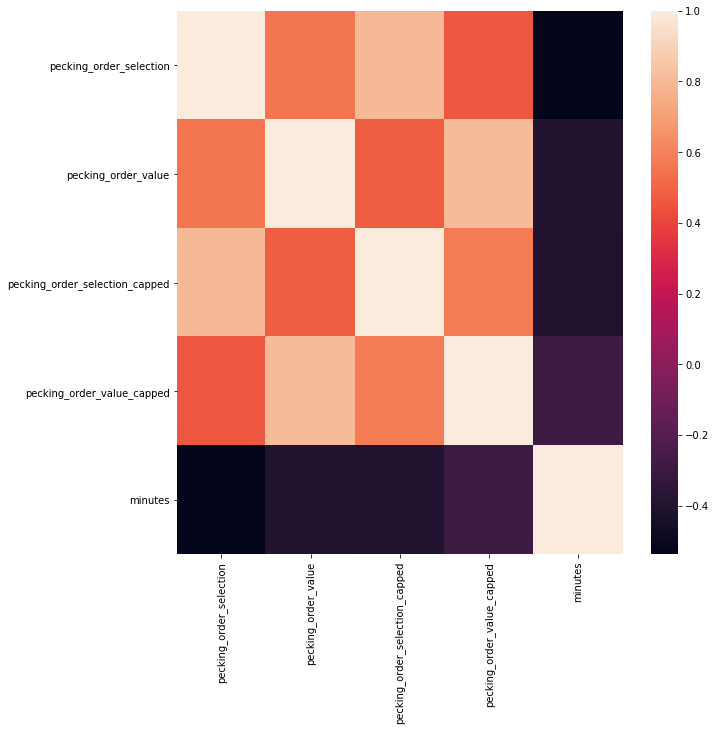

In [50]:
plt.figure(figsize=(10,10))
sns.heatmap(
    pecking_order_corr, 
)
plt.show()

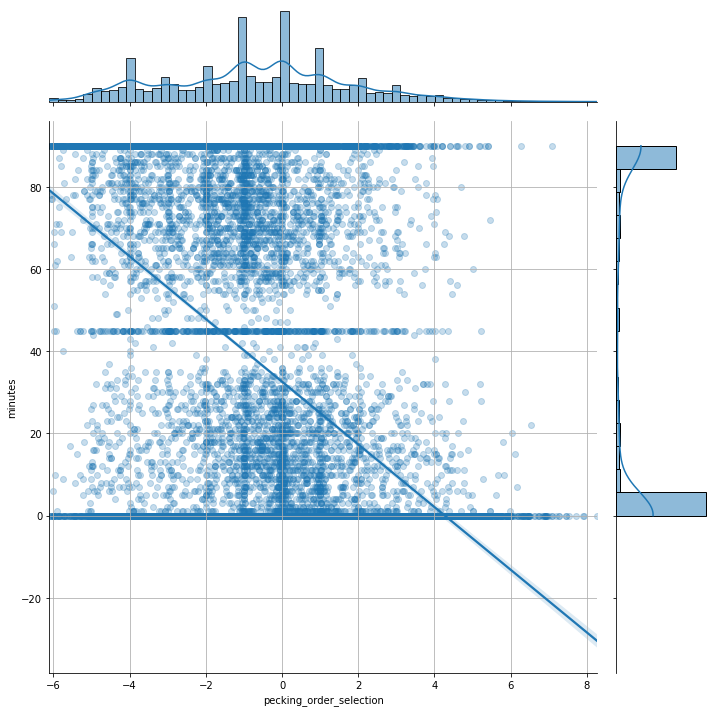

In [53]:
sns.jointplot(
    x='pecking_order_selection',
    y='minutes',
    data=profile_df,
    kind='reg',
    height=10,
    joint_kws = {'scatter_kws':dict(alpha=0.25)}
)
plt.grid()
plt.show()

## Estimated minutes

In [104]:
profile_df['estimated_minutes_residuals'] = profile_df['minutes'] - profile_df['estimated_minutes']
profile_df['estimated_minutes_residuals_abs'] = np.abs(profile_df['estimated_minutes_residuals'])

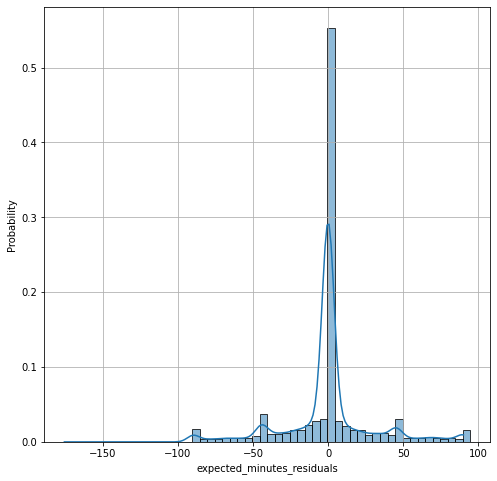

In [105]:
plt.figure(figsize=(8,8))
sns.histplot(
    data=profile_df,
    x='estimated_minutes_residuals',
    binwidth=5,
    kde=True,
    stat='probability'
)
plt.grid()
plt.show()

In [106]:
profile_df['estimated_minutes_residuals_abs'].describe(np.linspace(0.1, 0.9, 9))

count    23038.000000
mean        15.935434
std         24.769725
min          0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          6.500000
70%         17.409987
80%         36.500000
90%         51.000000
max        175.501045
Name: expected_minutes_residuals_abs, dtype: float64

In [107]:
profile_df.groupby('status')['estimated_minutes_residuals_abs'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
available,19379.0,17.431607,25.095536,0.0,0.0,2.000000,31.000000,90.000000
doubtful,1302.0,20.642409,29.746717,0.0,0.0,4.232854,28.998835,175.501045
unavailable,2357.0,1.033941,8.820298,0.0,0.0,0.000000,0.000000,90.000000


## Decision tree

In [54]:
list(profile_df.columns)

['element_all',
 'safe_web_name',
 'event',
 'kickoff_time',
 'minutes',
 'team',
 'element_type',
 'value',
 'status',
 'availability',
 'injury_type',
 'is_unknown_return_date',
 'days_until_return',
 'avg_minutes_p1',
 'avg_minutes_p2',
 'avg_minutes_p3',
 'avg_minutes_p4',
 'avg_minutes_p5',
 'avg_minutes_p10',
 'avg_minutes_p15',
 'avg_minutes_p20',
 'avg_minutes_p30',
 'avg_available_minutes_p1',
 'avg_available_minutes_p2',
 'avg_available_minutes_p3',
 'avg_available_minutes_p4',
 'avg_available_minutes_p5',
 'avg_available_minutes_p10',
 'avg_available_minutes_p15',
 'avg_available_minutes_p20',
 'avg_available_minutes_p30',
 'lagged_minutes_p1',
 'lagged_minutes_p2',
 'lagged_minutes_p3',
 'lagged_minutes_p4',
 'lagged_minutes_p5',
 'lagged_minutes_p6',
 'lagged_minutes_p7',
 'lagged_minutes_p8',
 'lagged_minutes_p9',
 'lagged_minutes_p10',
 'num_teammates_available_more_selected',
 'avg_num_players_in_position_p5',
 'pecking_order_selection',
 'pecking_order_value',
 'peckin

In [55]:
dt_numerical_features = [
     'value',
     'availability',
     'avg_minutes_p1',
     'avg_minutes_p2',
     'avg_minutes_p3',
     'avg_minutes_p4',
     'avg_minutes_p5',
     'avg_minutes_p10',
     'avg_minutes_p15',
     'avg_minutes_p20',
     'avg_minutes_p30',
     'avg_available_minutes_p1',
     'avg_available_minutes_p2',
     'avg_available_minutes_p3',
     'avg_available_minutes_p4',
     'avg_available_minutes_p5',
     'avg_available_minutes_p10',
     'avg_available_minutes_p15',
     'avg_available_minutes_p20',
     'avg_available_minutes_p30',
     'lagged_minutes_p1',
     'lagged_minutes_p2',
     'lagged_minutes_p3',
     'lagged_minutes_p4',
     'lagged_minutes_p5',
     'lagged_minutes_p6',
     'lagged_minutes_p7',
     'lagged_minutes_p8',
     'lagged_minutes_p9',
     'lagged_minutes_p10',
     'pecking_order_selection',
     'pecking_order_value',
]

dt_categorical_features = [
    'team',
    'element_type',
    'status',
    'injury_type',
    'is_unknown_return_date',   
]

numerical_transformer = Pipeline(
        [
            ('num_impute', SimpleImputer()),
        ]
    )

categorical_transformer = Pipeline(
    [
        ('cat_impute', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encode', OrdinalEncoder()),
    ]
)

preprocess = ColumnTransformer(
    [
        ('num', numerical_transformer, dt_numerical_features),
        ('cat', categorical_transformer, dt_categorical_features),
    ]
)

model = Pipeline([
    ('preprocess', preprocess),
    ('model', DecisionTreeRegressor(max_depth=3))
])

model.fit(profile_df[dt_numerical_features+dt_categorical_features], profile_df['minutes'])

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                              

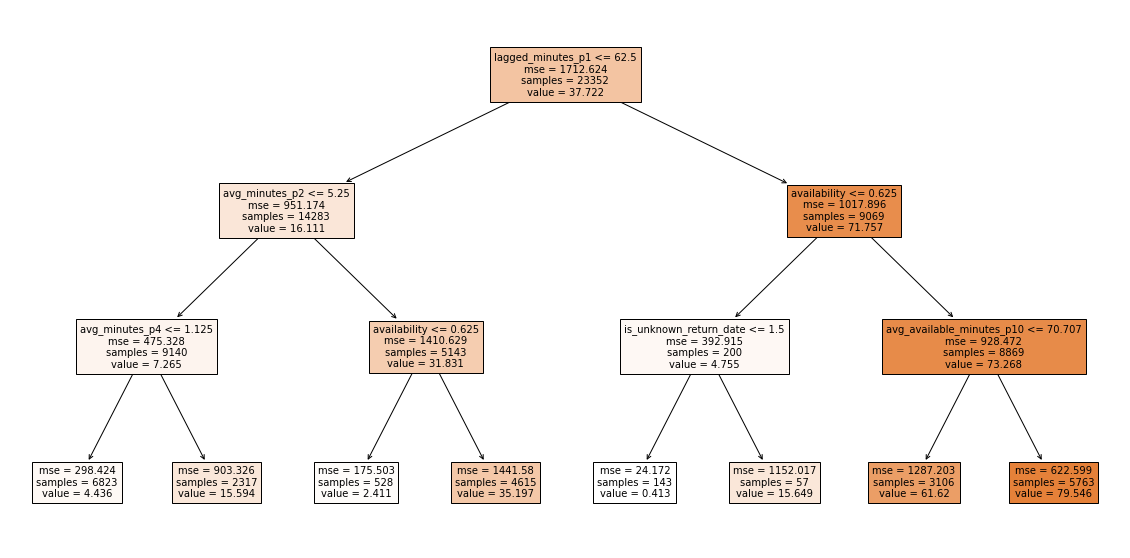

In [56]:
plt.figure(figsize=(20, 10))
plot_tree(
    model.named_steps['model'],
    feature_names=dt_numerical_features+dt_categorical_features,
    filled=True,
    proportion=False,
    rotate=True,
    rounded=False,
    precision=3,
    ax=None,
    fontsize=10
)
plt.show()

# Splitting data

In [6]:
df_train_validate, df_test = train_test_split(
    df, test_size=0.2, random_state=0)

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

train_df_arr = []
validate_df_arr = []

for train_index, validate_index in kf.split(df_train_validate):
    train_df_arr.append(df_train_validate.iloc[train_index])
    validate_df_arr.append(df_train_validate.iloc[validate_index])

In [8]:
target_variable = 'minutes'
y_train_validate = (df_train_validate[target_variable])
y_test = df_test[target_variable]
y = df[target_variable]

# Preprocessing

In [9]:
def get_preprocessing_pipeline(
    categorical_features,
    numerical_features
):

    numerical_transformer = Pipeline(
        [
            ('num_impute', SimpleImputer()),
        ]
    )

    categorical_transformer = Pipeline(
        [
            ('cat_impute', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]
    )

    preprocess = ColumnTransformer(
        [
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features,)
        ]
    )

    return preprocess

# Tuning models

In [10]:
def tune_hyperparameters(
    space,
    model,
    X,
    y,
    n_calls,
    n_random_starts
):

    tune_values = []
    tune_scores = []

    @use_named_args(space)
    def objective(**params):
        model.set_params(**params)

        scores = cross_val_score(
            model,
            X,
            y,
            cv=5,
            scoring='neg_mean_squared_error',
            error_score=-10000,
            n_jobs=-1
        )

        tune_values.append(params)
        tune_scores.append(scores)

        return -np.mean(scores)

    results = gp_minimize(
        objective,
        space,
        n_calls=n_calls,
        n_random_starts=n_random_starts,
        verbose=2
    )
    
    return {
        'tune_values': tune_values,
        'tune_scores': tune_scores,
        'results': results
    }

In [11]:
def visualise_tuning_results(
    tune_results,
    space,
    ylim=None
):
    df = pd.DataFrame(tune_results['tune_values'])
    df.columns = [i.split('__')[1] for i in df.columns]
    df['score'] = tune_results['tune_scores']
    df['score'] = -df['score']
    df = df.explode('score')
    df['score'] = pd.to_numeric(df['score'])

    for p in space:
        parameter_name = p.name.split('__')[1]

        if p.prior == 'log-uniform':
            log_parameter_name = 'log10_' + parameter_name
            df[log_parameter_name] = np.log10(df[parameter_name])
            parameter_name = log_parameter_name
        
        if not ylim:
            ylim = df['score'].max()

        sns.relplot(
            x=parameter_name,
            y='score',
            kind='line',
            data=df[df['score'] < ylim],
            height=7.5
        )
        plt.grid()
        if ylim:
            plt.ylim = ylim
        plt.title(parameter_name + ' against mean cv score')
        plt.show()

# Modelling

## Features

In [12]:
list(df.columns)

['element_all',
 'safe_web_name',
 'event',
 'kickoff_time',
 'minutes',
 'team',
 'element_type',
 'value',
 'status',
 'availability',
 'injury_type',
 'avg_injury_type_minutes',
 'estimated_injury_type_minutes',
 'is_unknown_return_date',
 'days_until_return',
 'days_since_returned_from_injury',
 'transfers_in',
 'transfers_out',
 'net_transfers_in',
 'avg_minutes_p1',
 'avg_minutes_p2',
 'avg_minutes_p3',
 'avg_minutes_p4',
 'avg_minutes_p5',
 'avg_minutes_p10',
 'avg_available_minutes_p1',
 'avg_available_minutes_p2',
 'avg_available_minutes_p3',
 'avg_available_minutes_p4',
 'avg_available_minutes_p5',
 'avg_available_minutes_p10',
 'avg_available_minutes_all_players_p3',
 'estimated_minutes']

## Benchmark model

### Configuration

In [15]:
bm_categorical_features = []
bm_numerical_features = [
    'avg_minutes_p1'
]

bm_X_train_validate = df_train_validate[bm_categorical_features+bm_numerical_features]

bm_preprocess_pipeline = get_preprocessing_pipeline(bm_categorical_features, bm_numerical_features)

bm_model = Pipeline([
    ('preprocess', bm_preprocess_pipeline),
    ('linear regression', LinearRegression())
])

### Results

In [16]:
bm_validate_results = cross_validate(
    bm_model,
    bm_X_train_validate,
    y_train_validate,
    scoring=['neg_mean_squared_error', 'neg_median_absolute_error', 'r2'],
    cv=kf,
    return_train_score=True
)

bm_validate_results_df = pd.DataFrame(
    [(k, bm_validate_results[k].mean(), bm_validate_results[k].std()) for k in bm_validate_results.keys()]
)

bm_validate_results_df['model'] = 'benchmark'
bm_validate_results_df.columns = ['metric', 'mean', 'std', 'model']
bm_validate_results_df[['model', 'metric', 'mean', 'std']].sort_values('metric').round(2)

,model,metric,mean,std
0,benchmark,fit_time,0.01,0.00
1,benchmark,score_time,0.00,0.00
2,benchmark,test_neg_mean_squared_error,-879.50,9.90
4,benchmark,test_neg_median_absolute_error,-15.36,0.10
6,benchmark,test_r2,0.49,0.00
3,benchmark,train_neg_mean_squared_error,-879.43,2.45
5,benchmark,train_neg_median_absolute_error,-15.36,0.10
7,benchmark,train_r2,0.49,0.00


## Least squares model

### Configuration

In [78]:
ls_categorical_features = [
    'status',
    'element_type'
]

ls_numerical_features = [
    'value',
    'availability',
    'avg_injury_type_minutes',
    'estimated_injury_type_minutes',
    'transfers_in',
    'transfers_out',
    'net_transfers_in',
    'avg_minutes_p1',
    'avg_minutes_p2',
    'avg_minutes_p3',
    'avg_minutes_p4',
    'avg_minutes_p5',
    'avg_minutes_p10',
    'avg_available_minutes_p1',
    'avg_available_minutes_p2',
    'avg_available_minutes_p3',
    'avg_available_minutes_p4',
    'avg_available_minutes_p5',
    'avg_available_minutes_p10',
    'estimated_minutes'
]

ls_X_train_validate = df_train_validate[ls_categorical_features+ls_numerical_features]

ls_preprocess_pipeline = get_preprocessing_pipeline(ls_categorical_features, ls_numerical_features)

ls_model = Pipeline([
    ('preprocess', ls_preprocess_pipeline),
    ('linear regression', LinearRegression())
])

### Results

In [84]:
ls_validate_results = cross_validate(
    ls_model,
    ls_X_train_validate,
    y_train_validate,
    scoring=['neg_mean_squared_error', 'neg_median_absolute_error', 'r2'],
    cv=kf,
    return_train_score=True
)

ls_validate_results_df = pd.DataFrame(
    [(k, ls_validate_results[k].mean(), ls_validate_results[k].std()) for k in ls_validate_results.keys()]
)

ls_validate_results_df['model'] = 'least_squares'
ls_validate_results_df.columns = ['metric', 'mean', 'std', 'model']
ls_validate_results_df[['model', 'metric', 'mean', 'std']].sort_values('metric').round(2)

,model,metric,mean,std
0,least_squares,fit_time,0.06,0.01
1,least_squares,score_time,0.01,0.00
2,least_squares,test_neg_mean_squared_error,-723.04,12.57
4,least_squares,test_neg_median_absolute_error,-10.61,0.12
6,least_squares,test_r2,0.58,0.01
3,least_squares,train_neg_mean_squared_error,-720.41,3.16
5,least_squares,train_neg_median_absolute_error,-10.62,0.09
7,least_squares,train_r2,0.58,0.00


## Ridge model

### Configuration

In [19]:
ridge_categorical_features = [
    'status',
    'element_type'
]

ridge_numerical_features = [
    'value',
    'availability',
    'avg_injury_type_minutes',
    'estimated_injury_type_minutes',
    'transfers_in',
    'transfers_out',
    'net_transfers_in',
    'avg_minutes_p1',
    'avg_minutes_p2',
    'avg_minutes_p3',
    'avg_minutes_p4',
    'avg_minutes_p5',
    'avg_minutes_p10',
    'avg_available_minutes_p1',
    'avg_available_minutes_p2',
    'avg_available_minutes_p3',
    'avg_available_minutes_p4',
    'avg_available_minutes_p5',
    'avg_available_minutes_p10',
    'estimated_minutes'
]

ridge_X_train_validate = df_train_validate[ridge_categorical_features+ridge_numerical_features]

ridge_preprocess_pipeline = get_preprocessing_pipeline(ridge_categorical_features, ridge_numerical_features)

ridge_model = Pipeline([
    ('preprocess', ridge_preprocess_pipeline),
    ('model', Ridge())
])

### Tuning

In [20]:
ridge_space  = [
    Real(10**-6, 10**6, 'log-uniform', name='model__alpha')
]

ridge_tune_results = tune_hyperparameters(
    ridge_space,
    ridge_model,
    ridge_X_train_validate,
    y_train_validate,
    30,
    10
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.1919
Function value obtained: 731.4128
Current minimum: 731.4128
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2183
Function value obtained: 722.5378
Current minimum: 722.5378
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2290
Function value obtained: 730.4517
Current minimum: 722.5378
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2199
Function value obtained: 724.4153
Current minimum: 722.5378
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2228
Function value obtained: 731.9508
Current minimum: 722.5378
Iteration No: 6

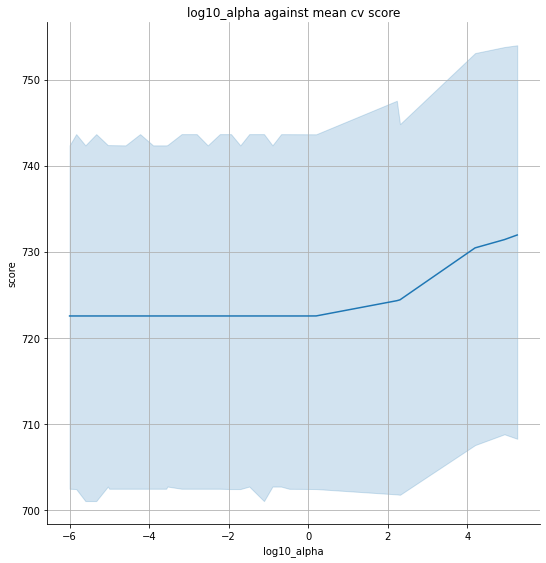

In [21]:
visualise_tuning_results(
    ridge_tune_results,
    ridge_space,
    ylim=1000
)

In [22]:
ridge_model = Pipeline([
    ('preprocess', ridge_preprocess_pipeline),
    ('model', Ridge(alpha=0.0001))
])

### Results

In [24]:
ridge_validate_results = cross_validate(
    ridge_model,
    ridge_X_train_validate,
    y_train_validate,
    scoring=['neg_mean_squared_error', 'neg_median_absolute_error', 'r2'],
    cv=kf,
    return_train_score=True
)

ridge_validate_results_df = pd.DataFrame(
    [(k, ridge_validate_results[k].mean(), ridge_validate_results[k].std()) for k in ridge_validate_results.keys()]
)

ridge_validate_results_df['model'] = 'ridge'
ridge_validate_results_df.columns = ['metric', 'mean', 'std', 'model']
ridge_validate_results_df[['model', 'metric', 'mean', 'std']].sort_values('metric').round(2)

/Users/thomaswoodruff/code/footbot/venv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.29932e-18): result may not be accurate.
  overwrite_a=True).T
/Users/thomaswoodruff/code/footbot/venv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.28963e-18): result may not be accurate.
  overwrite_a=True).T


,model,metric,mean,std
0,ridge,fit_time,0.06,0.01
1,ridge,score_time,0.01,0.00
2,ridge,test_neg_mean_squared_error,-723.03,12.58
4,ridge,test_neg_median_absolute_error,-10.61,0.12
6,ridge,test_r2,0.58,0.01
3,ridge,train_neg_mean_squared_error,-720.41,3.16
5,ridge,train_neg_median_absolute_error,-10.62,0.09
7,ridge,train_r2,0.58,0.00


## Random forest model

### Configuration

In [41]:
rf_categorical_features = [
    'status',
    'element_type'
]

rf_numerical_features = [
    'value',
    'availability',
    'avg_injury_type_minutes',
    'estimated_injury_type_minutes',
    'transfers_in',
    'transfers_out',
    'net_transfers_in',
    'avg_minutes_p1',
    'avg_minutes_p2',
    'avg_minutes_p3',
    'avg_minutes_p4',
    'avg_minutes_p5',
    'avg_minutes_p10',
    'avg_available_minutes_p1',
    'avg_available_minutes_p2',
    'avg_available_minutes_p3',
    'avg_available_minutes_p4',
    'avg_available_minutes_p5',
    'avg_available_minutes_p10',
    'estimated_minutes'
]

rf_X_train_validate = df_train_validate[rf_categorical_features+rf_numerical_features]

rf_preprocess_pipeline = get_preprocessing_pipeline(rf_categorical_features, rf_numerical_features)

rf_model = Pipeline([
    ('preprocess', rf_preprocess_pipeline),
    ('model', RandomForestRegressor(n_jobs=-1))
])

### Tuning

In [26]:
rf_space  = [
    Integer(100, 2000, name='model__n_estimators'),
    Integer(1, 20, name='model__max_depth'),
    Real(10**-10, 10**-1, 'log-uniform', name='model__min_samples_leaf'),
    Real(0.1, 1.0, 'uniform', name='model__max_features'),
    Real(0.1, 1.0, 'uniform', name='model__max_samples')
]

rf_tune_results = tune_hyperparameters(
    rf_space,
    rf_model,
    rf_X_train_validate,
    y_train_validate,
    50,
    20
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 35.2657
Function value obtained: 684.5001
Current minimum: 684.5001
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 151.4081
Function value obtained: 686.7779
Current minimum: 684.5001
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 54.4692
Function value obtained: 759.2762
Current minimum: 684.5001
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 135.4880
Function value obtained: 690.6737
Current minimum: 684.5001
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 19.3526
Function value obtained: 682.8930
Current minimum: 682.8930
Iteratio

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 28.3485
Function value obtained: 685.0507
Current minimum: 681.6960
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 46.4600
Function value obtained: 709.7100
Current minimum: 681.6960
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 44.4546
Function value obtained: 696.2142
Current minimum: 681.6960
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 28.6939
Function value obtained: 686.1555
Current minimum: 681.6960
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 238.5414
Function value obtained: 690.5806
Current minimum: 681.6960
Ite

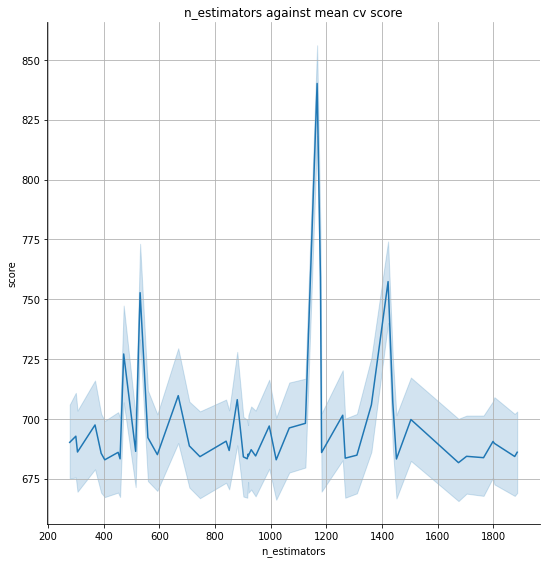

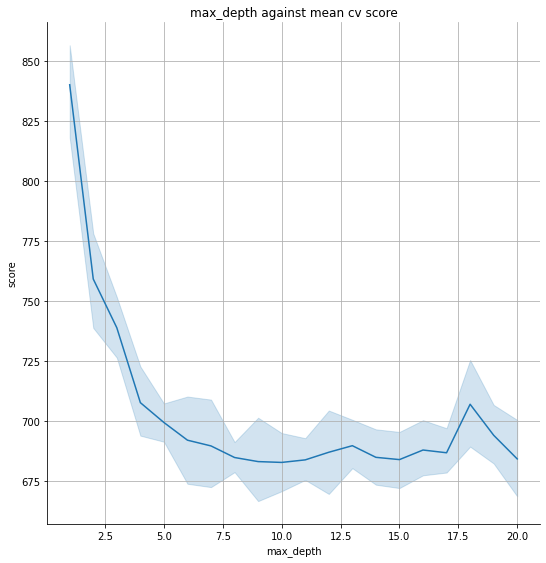

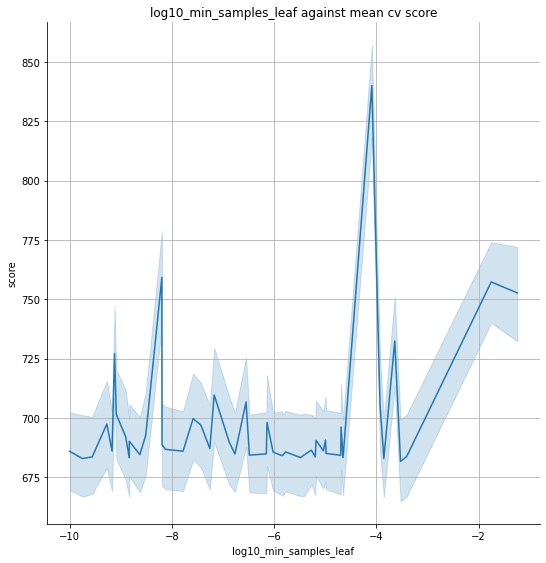

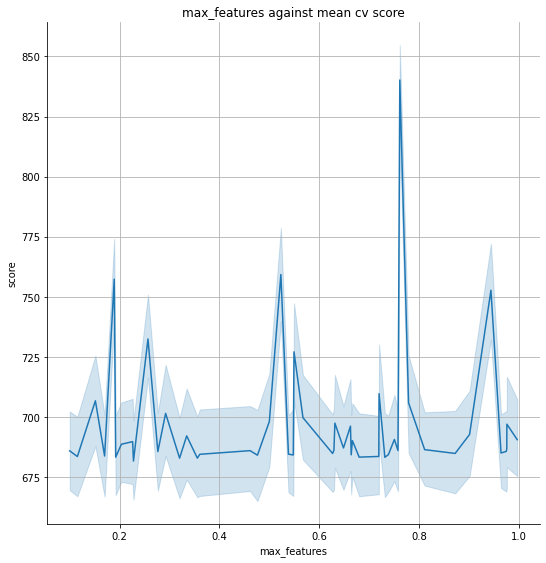

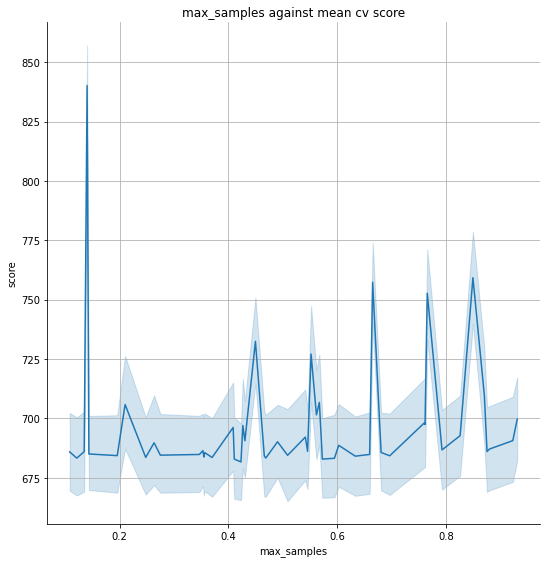

In [27]:
visualise_tuning_results(
    rf_tune_results,
    rf_space,
    ylim=1000
)

In [29]:
rf_tune_results['results'].x

[1675, 11, 0.0002975029392013939, 0.22778720880751124, 0.42304227258007054]

In [67]:
rf_model = Pipeline([
    ('preprocess', rf_preprocess_pipeline),
    ('model', RandomForestRegressor(
        n_estimators=1700,
        max_depth=11,
        min_samples_leaf=0.00030,
        max_features=0.23,
        max_samples=0.42,
        n_jobs=-1
))
])

### Results

In [68]:
rf_validate_results = cross_validate(
    rf_model,
    rf_X_train_validate,
    y_train_validate,
    scoring=['neg_mean_squared_error', 'neg_median_absolute_error', 'r2'],
    cv=kf,
    return_train_score=True,
    n_jobs=-1
)

rf_validate_results_df = pd.DataFrame(
    [(k, rf_validate_results[k].mean(), rf_validate_results[k].std()) for k in rf_validate_results.keys()]
)

rf_validate_results_df['model'] = 'random forest'
rf_validate_results_df.columns = ['metric', 'mean', 'std', 'model']
rf_validate_results_df[['model', 'metric', 'mean', 'std']].sort_values('metric').round(2)


,model,metric,mean,std
0,random forest,fit_time,29.67,10.04
1,random forest,score_time,1.01,0.25
2,random forest,test_neg_mean_squared_error,-681.68,11.71
4,random forest,test_neg_median_absolute_error,-9.95,0.17
6,random forest,test_r2,0.60,0.01
3,random forest,train_neg_mean_squared_error,-557.83,2.85
5,random forest,train_neg_median_absolute_error,-9.10,0.10
7,random forest,train_r2,0.67,0.00


## Gradient boosted trees

### Configuration

In [69]:
gbt_categorical_features = [
    'status',
    'element_type'
]

gbt_numerical_features = [
    'value',
    'availability',
    'avg_injury_type_minutes',
    'estimated_injury_type_minutes',
    'transfers_in',
    'transfers_out',
    'net_transfers_in',
    'avg_minutes_p1',
    'avg_minutes_p2',
    'avg_minutes_p3',
    'avg_minutes_p4',
    'avg_minutes_p5',
    'avg_minutes_p10',
    'avg_available_minutes_p1',
    'avg_available_minutes_p2',
    'avg_available_minutes_p3',
    'avg_available_minutes_p4',
    'avg_available_minutes_p5',
    'avg_available_minutes_p10',
    'estimated_minutes'
]

gbt_X_train_validate = df_train_validate[gbt_categorical_features+gbt_numerical_features]

gbt_preprocess_pipeline = get_preprocessing_pipeline(gbt_categorical_features, gbt_numerical_features)

gbt_model = Pipeline([
    ('preprocess', gbt_preprocess_pipeline),
    ('model', GradientBoostingRegressor())
])

### Tuning

In [70]:
gbt_space  = [
    Real(10**-8, 10**-0, 'log-uniform', name='model__learning_rate'),
    Integer(10, 2000, name='model__n_estimators'),
    Real(0.1, 1.0, 'uniform', name='model__subsample'),
    Integer(1, 20, name='model__max_depth'),
    Real(10**-10, 10**-1, 'log-uniform', name='model__min_samples_leaf'),
    Real(0.1, 1.0, 'uniform', name='model__max_features'),
]

gbt_tune_results = tune_hyperparameters(
    gbt_space,
    gbt_model,
    gbt_X_train_validate,
    y_train_validate,
    50,
    20
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 222.8083
Function value obtained: 755.0398
Current minimum: 755.0398
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 175.4366
Function value obtained: 1714.1795
Current minimum: 755.0398
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 22.0885
Function value obtained: 846.5363
Current minimum: 755.0398
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 176.4589
Function value obtained: 1344.1967
Current minimum: 755.0398
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 9.6125
Function value obtained: 1714.3077
Current minimum: 755.0398
Itera

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 93.8362
Function value obtained: 678.5672
Current minimum: 677.7725
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 98.2198
Function value obtained: 678.7111
Current minimum: 677.7725
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 112.5364
Function value obtained: 683.7211
Current minimum: 677.7725
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 96.3146
Function value obtained: 679.6938
Current minimum: 677.7725
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 101.1345
Function value obtained: 678.5603
Current minimum: 677.7725
It

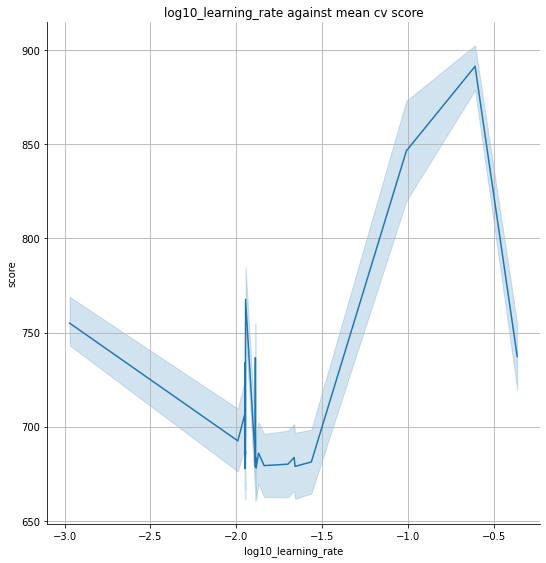

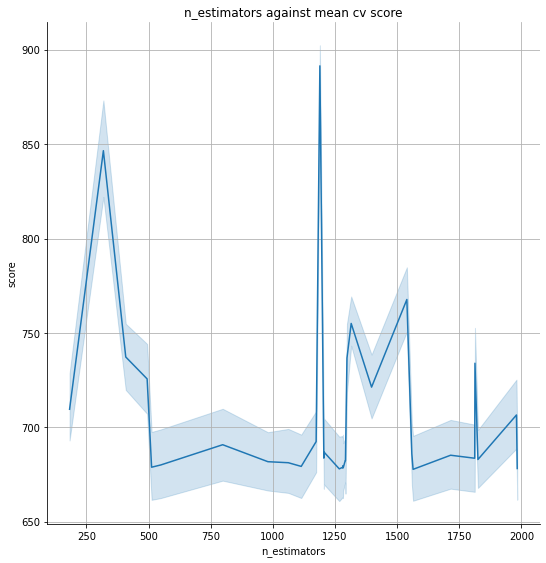

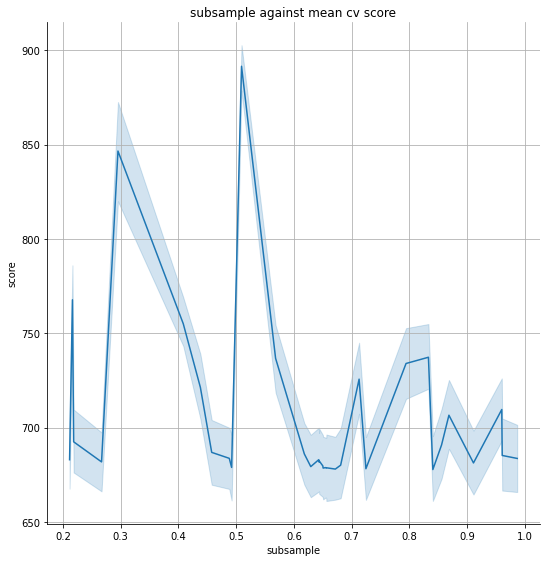

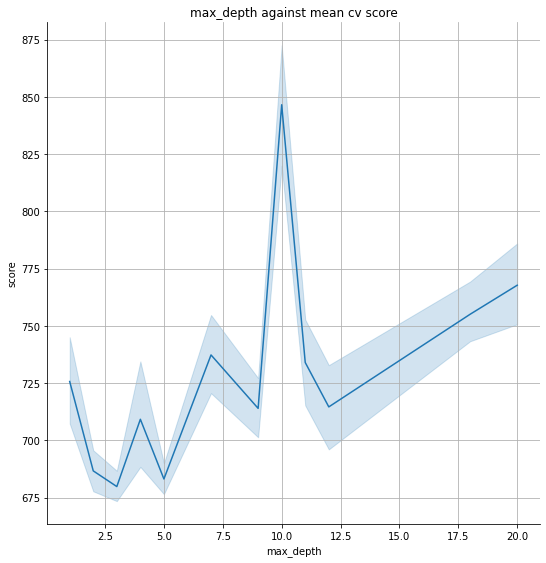

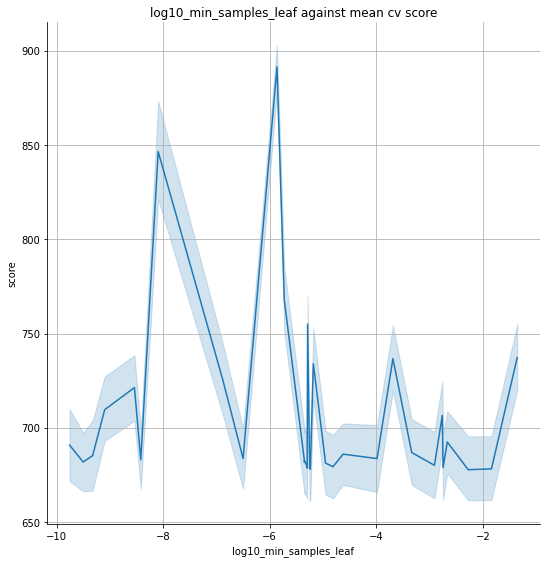

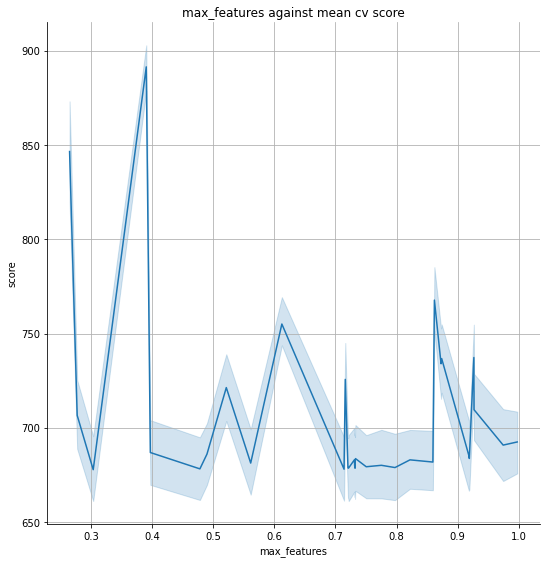

In [71]:
visualise_tuning_results(
    gbt_tune_results,
    gbt_space,
    ylim=1000
)

In [72]:
gbt_tune_results['results'].x

[0.011269630830463053,
 1564,
 0.8407302397067109,
 3,
 0.005289835107303153,
 0.303980055250205]

In [74]:
gbt_model = Pipeline([
    ('preprocess', gbt_preprocess_pipeline),
    ('model', GradientBoostingRegressor(
        learning_rate=0.011,
        n_estimators=1500,
        subsample=0.84,
        max_depth=3,
        min_samples_leaf=0.0053,
        max_features=0.30
    ))
])

### Results

In [83]:
gbt_validate_results = cross_validate(
    gbt_model,
    gbt_X_train_validate,
    y_train_validate,
    scoring=['neg_mean_squared_error', 'neg_median_absolute_error', 'r2'],
    cv=kf,
    return_train_score=True
)

gbt_validate_results_df = pd.DataFrame(
    [(k, gbt_validate_results[k].mean(), gbt_validate_results[k].std()) for k in gbt_validate_results.keys()]
)

gbt_validate_results_df['model'] = 'gradient boosted trees'
gbt_validate_results_df.columns = ['metric', 'mean', 'std', 'model']
gbt_validate_results_df[['model', 'metric', 'mean', 'std']].sort_values('metric').round(2)

,model,metric,mean,std
0,gradient boosted trees,fit_time,26.40,6.59
1,gradient boosted trees,score_time,0.15,0.07
2,gradient boosted trees,test_neg_mean_squared_error,-677.60,13.20
4,gradient boosted trees,test_neg_median_absolute_error,-9.63,0.16
6,gradient boosted trees,test_r2,0.60,0.01
3,gradient boosted trees,train_neg_mean_squared_error,-634.70,3.25
5,gradient boosted trees,train_neg_median_absolute_error,-9.37,0.08
7,gradient boosted trees,train_r2,0.63,0.00


# Selecting models

In [85]:
pd.concat([
    bm_validate_results_df,
    ls_validate_results_df,
    ridge_validate_results_df,
    rf_validate_results_df,
    gbt_validate_results_df,
]).pivot(
    index='model',
    columns='metric',
    values='mean'
).reset_index()[[
    'model',
    'fit_time',
    'train_neg_mean_squared_error',
    'train_neg_median_absolute_error',
    'train_r2'
]]

metric,model,fit_time,train_neg_mean_squared_error,train_neg_median_absolute_error,train_r2
0,benchmark,0.008250,-879.429462,-15.359122,0.487006
1,gradient boosted trees,26.395328,-634.700662,-9.367726,0.629762
2,least_squares,0.059873,-720.405274,-10.616194,0.579769
3,random forest,29.674192,-557.828543,-9.099085,0.674604
4,ridge,0.058484,-720.405400,-10.616487,0.579769


In [86]:
pd.concat([
    bm_validate_results_df,
    ls_validate_results_df,
    ridge_validate_results_df,
    rf_validate_results_df,
    gbt_validate_results_df,
]).pivot(
    index='model',
    columns='metric',
    values='mean'
).reset_index()[[
    'model',
    'fit_time',
    'test_neg_mean_squared_error',
    'test_neg_median_absolute_error',
    'test_r2'
]]

metric,model,fit_time,test_neg_mean_squared_error,test_neg_median_absolute_error,test_r2
0,benchmark,0.008250,-879.496608,-15.359122,0.486941
1,gradient boosted trees,26.395328,-677.601342,-9.625428,0.604715
2,least_squares,0.059873,-723.035310,-10.614565,0.578215
3,random forest,29.674192,-681.675649,-9.947833,0.602339
4,ridge,0.058484,-723.028964,-10.614558,0.578219


In [87]:
pd.concat([
    bm_validate_results_df,
    ls_validate_results_df,
    ridge_validate_results_df,
    rf_validate_results_df,
    gbt_validate_results_df,
]).pivot(
    index='model',
    columns='metric',
    values='std'
).reset_index()[[
    'model',
    'fit_time',
    'test_neg_mean_squared_error',
    'test_neg_median_absolute_error',
    'test_r2'
]]

metric,model,fit_time,test_neg_mean_squared_error,test_neg_median_absolute_error,test_r2
0,benchmark,0.002100,9.900209,0.100772,0.003236
1,gradient boosted trees,6.585993,13.200713,0.157798,0.006881
2,least_squares,0.005034,12.574129,0.115467,0.006077
3,random forest,10.035352,11.706861,0.171415,0.005840
4,ridge,0.014662,12.575014,0.115461,0.006076


# Inspecting model

In [104]:
df_train_inspect, df_test_inspect = train_test_split(
    df_train_validate.copy(), test_size=0.2, random_state=0)

y_train_inspect = df_train_inspect[target_variable]
y_test_inspect = df_test_inspect[target_variable]

In [105]:
rf_X_train_inspect = df_train_inspect[rf_categorical_features+rf_numerical_features]
rf_X_test_inspect = df_test_inspect[rf_categorical_features+rf_numerical_features]

rf_model_inspect = rf_model

In [106]:
rf_model_inspect.fit(rf_X_train_inspect, y_train_inspect)

pred_test_inspect = rf_model_inspect.predict(rf_X_test_inspect)

df_test_inspect['predicted_minutes'] = pred_test_inspect
df_test_inspect['residuals'] = df_test_inspect['minutes'] - df_test_inspect['predicted_minutes']

## Inspecting residuals

In [29]:
np.abs(df_test_inspect['residuals']).describe(np.linspace(0.1, 0.9, 9))

count    3752.000000
mean       17.565307
std        19.477820
min         0.034079
10%         1.662084
20%         3.142145
30%         4.654465
40%         6.515593
50%         9.602518
60%        14.055809
70%        19.762151
80%        29.798879
90%        47.650343
max        88.702569
Name: residuals, dtype: float64

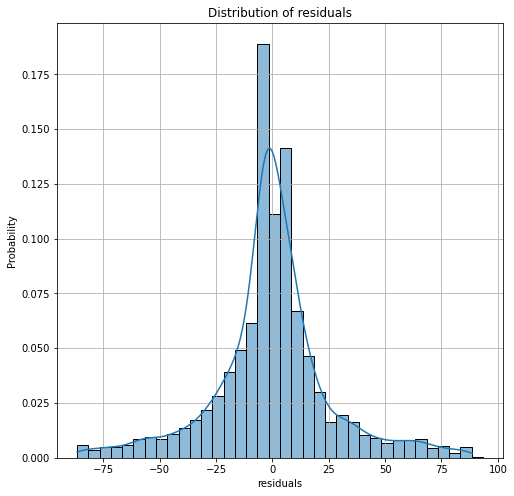

In [30]:
plt.figure(figsize=(8,8))
sns.histplot(
    data=df_test_inspect,
    x='residuals',
    binwidth=5,
    kde=True,
    stat='probability'
)
plt.title('Distribution of residuals')
plt.grid()
plt.show()

In [160]:
df_test_inspect[df_test_inspect['residuals'] < -60].sample(20)

,element_all,safe_web_name,event,kickoff_time,minutes,team,element_type,value,status,availability,injury_type,avg_injury_type_minutes,expected_injury_type_minutes,is_unknown_return_date,days_until_return,avg_minutes_p1,avg_minutes_p2,avg_minutes_p3,avg_minutes_p4,avg_minutes_p5,avg_minutes_p10,avg_minutes_p15,avg_minutes_p20,avg_minutes_p30,avg_available_minutes_p1,avg_available_minutes_p2,avg_available_minutes_p3,avg_available_minutes_p4,avg_available_minutes_p5,avg_available_minutes_p10,avg_available_minutes_p15,avg_available_minutes_p20,avg_available_minutes_p30,avg_available_minutes_p1_1,avg_available_minutes_p2_1,avg_available_minutes_p3_1,avg_available_minutes_p4_1,avg_available_minutes_p5_1,avg_available_minutes_p10_1,avg_available_minutes_p15_1,avg_available_minutes_p20_1,avg_available_minutes_p30_1,lagged_minutes_p1,lagged_minutes_p2,lagged_minutes_p3,lagged_minutes_p4,lagged_minutes_p5,lagged_minutes_p6,lagged_minutes_p7,lagged_minutes_p8,lagged_minutes_p9,lagged_minutes_p10,avg_minutes_all_players_p1,avg_minutes_all_players_p2,avg_minutes_all_players_p3,avg_minutes_all_players_p4,avg_minutes_all_players_p5,avg_minutes_all_players_p10,avg_minutes_all_players_p15,avg_minutes_all_players_p20,avg_minutes_all_players_p30,avg_available_minutes_all_players_p1,avg_available_minutes_all_players_p2,avg_available_minutes_all_players_p3,avg_available_minutes_all_players_p4,avg_available_minutes_all_players_p5,avg_available_minutes_all_players_p10,avg_available_minutes_all_players_p15,avg_available_minutes_all_players_p20,avg_available_minutes_all_players_p30,num_teammates_available_more_selected,avg_num_players_in_position_p5,pecking_order_selection,pecking_order_value,pecking_order_selection_capped,pecking_order_value_capped,expected_minutes,predicted_minutes,residuals
8189,448,felipe anderson,17,2019-12-14 17:30:00+00:00,0,west ham,3,67,available,1.0,NaN,NaN,0.0,NaN,NaN,69.0,79.500000,76.333333,68.50,65.800000,70.900000,71.769231,71.769231,71.769231,69.0,79.500000,76.333333,68.500000,65.800000,70.900000,71.769231,71.769231,71.769231,69.0,79.500000,76.333333,68.500000,65.800000,70.900000,71.769231,71.769231,71.769231,69.0,90.0,70.0,45.0,55.0,90.0,65.0,45.0,90.0,90.0,34.992908,34.955634,35.073547,35.131907,35.205357,35.534355,35.855643,35.855643,35.855643,44.116279,44.208868,44.716301,44.943986,44.780660,45.141369,45.561187,45.561187,45.561187,1,5.242222,-4.242222,-4.242222,0.000000,0.000000,79.500000,61.345288,-61.345288
8179,1133,bardsley,39,2020-06-22 19:00:00+00:00,0,burnley,2,43,available,1.0,NaN,NaN,0.0,NaN,NaN,90.0,90.000000,90.000000,90.00,72.000000,63.000000,66.000000,63.000000,48.461538,90.0,90.000000,90.000000,90.000000,72.000000,63.000000,69.230769,68.823529,50.869565,90.0,90.000000,90.000000,90.000000,72.000000,63.000000,69.230769,68.823529,50.869565,90.0,90.0,90.0,90.0,0.0,0.0,90.0,0.0,90.0,90.0,28.799414,29.962838,30.583610,30.922855,31.115094,32.200330,32.963273,33.555326,34.201964,39.412371,40.685647,41.697134,41.937608,41.959230,42.779295,43.309653,43.747729,44.346070,2,4.000000,-2.000000,-3.000000,0.000000,0.000000,90.000000,80.048226,-80.048226
8994,586,stephens,3,2020-09-26 19:00:00+00:00,0,southampton,2,50,available,1.0,NaN,NaN,0.0,NaN,NaN,90.0,90.000000,90.000000,90.00,72.000000,71.400000,77.600000,80.700000,83.800000,90.0,90.000000,90.000000,90.000000,72.000000,79.333333,83.142857,84.947368,86.689655,90.0,90.000000,90.000000,90.000000,72.000000,79.333333,83.142857,84.947368,86.689655,90.0,90.0,90.0,90.0,0.0,90.0,90.0,90.0,0.0,84.0,37.024575,37.294492,34.194773,32.920565,32.268677,31.385968,31.281190,31.674642,32.671732,44.325688,44.441176,43.586151,43.278138,43.172333,42.725091,42.276640,42.483501,43.208855,1,3.740000,-2.740000,-3.740000,0.000000,0.000000,90.000000,87.894194,-87.894194
8795,372,jota,22,2020-01-11 15:00:00+00:00,0,wolves,4,61,available,1.0,NaN,NaN,0.0,NaN,NaN,24.0,47.500000,57.666667,62.25,67.800000,74.600000,62.200000,63.055556,63.055556,24.0,47.500000,57.666667,62.250000,67.800000,74.60

In [167]:
df_test_inspect[df_test_inspect['residuals'] < -60]['avg_available_minutes_p3'].describe()

count    110.000000
mean      74.366667
std       19.680848
min       24.000000
25%       62.333333
50%       84.000000
75%       90.000000
max       90.000000
Name: avg_available_minutes_p3, dtype: float64

In [168]:
df_test_inspect[df_test_inspect['residuals'] < -60]['avg_available_minutes_p30'].describe()

count    110.000000
mean      67.093672
std       20.412411
min        3.214286
25%       58.039583
50%       72.517241
75%       81.594022
max       90.000000
Name: avg_available_minutes_p30, dtype: float64

In [161]:
df_test_inspect[df_test_inspect['residuals'] > 60].sample(20)

,element_all,safe_web_name,event,kickoff_time,minutes,team,element_type,value,status,availability,injury_type,avg_injury_type_minutes,expected_injury_type_minutes,is_unknown_return_date,days_until_return,avg_minutes_p1,avg_minutes_p2,avg_minutes_p3,avg_minutes_p4,avg_minutes_p5,avg_minutes_p10,avg_minutes_p15,avg_minutes_p20,avg_minutes_p30,avg_available_minutes_p1,avg_available_minutes_p2,avg_available_minutes_p3,avg_available_minutes_p4,avg_available_minutes_p5,avg_available_minutes_p10,avg_available_minutes_p15,avg_available_minutes_p20,avg_available_minutes_p30,avg_available_minutes_p1_1,avg_available_minutes_p2_1,avg_available_minutes_p3_1,avg_available_minutes_p4_1,avg_available_minutes_p5_1,avg_available_minutes_p10_1,avg_available_minutes_p15_1,avg_available_minutes_p20_1,avg_available_minutes_p30_1,lagged_minutes_p1,lagged_minutes_p2,lagged_minutes_p3,lagged_minutes_p4,lagged_minutes_p5,lagged_minutes_p6,lagged_minutes_p7,lagged_minutes_p8,lagged_minutes_p9,lagged_minutes_p10,avg_minutes_all_players_p1,avg_minutes_all_players_p2,avg_minutes_all_players_p3,avg_minutes_all_players_p4,avg_minutes_all_players_p5,avg_minutes_all_players_p10,avg_minutes_all_players_p15,avg_minutes_all_players_p20,avg_minutes_all_players_p30,avg_available_minutes_all_players_p1,avg_available_minutes_all_players_p2,avg_available_minutes_all_players_p3,avg_available_minutes_all_players_p4,avg_available_minutes_all_players_p5,avg_available_minutes_all_players_p10,avg_available_minutes_all_players_p15,avg_available_minutes_all_players_p20,avg_available_minutes_all_players_p30,num_teammates_available_more_selected,avg_num_players_in_position_p5,pecking_order_selection,pecking_order_value,pecking_order_selection_capped,pecking_order_value_capped,expected_minutes,predicted_minutes,residuals
103,353,lovren,10,2019-10-27 16:30:00+00:00,90,liverpool,2,53,available,1.00,NaN,NaN,0.000000,NaN,NaN,0.0,45.000000,30.000000,22.50,18.000000,15.000000,15.000000,15.000000,15.000000,0.0,45.000000,30.000000,22.500000,18.000000,18.000000,18.000000,18.000000,18.000000,0.0,45.000000,30.000000,22.500000,18.000000,18.000000,18.000000,18.000000,18.000000,0.0,90.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,35.760436,35.967153,36.095966,36.205612,36.390018,36.528302,36.528302,36.528302,36.528302,45.272289,45.875747,45.862151,46.073583,46.545232,46.436127,46.436127,46.436127,46.436127,1,4.002222,-3.002222,-3.002222,0.0,0.0,45.000000,25.013850,64.986150
14592,611,milner,8,2019-10-05 14:00:00+00:00,90,liverpool,3,53,available,1.00,NaN,NaN,0.000000,NaN,NaN,3.0,11.000000,12.333333,9.25,9.250000,9.250000,9.250000,9.250000,9.250000,NaN,19.000000,17.000000,11.333333,11.333333,11.333333,11.333333,11.333333,11.333333,NaN,19.000000,17.000000,11.333333,11.333333,11.333333,11.333333,11.333333,11.333333,3.0,19.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,36.357407,36.448052,36.678061,36.816097,36.816097,36.816097,36.816097,36.816097,36.816097,45.834928,46.275274,47.009106,46.725478,46.725478,46.725478,46.725478,46.725478,46.725478,1,4.919444,-3.919444,-2.919444,0.0,0.0,19.000000,23.385523,66.614477
12944,1208,bennett,20,2019-12-29 16:30:00+00:00,90,wolves,2,49,available,1.00,NaN,NaN,0.000000,NaN,NaN,1.0,0.500000,0.333333,0.25,0.400000,0.600000,6.666667,11.875000,11.875000,1.0,0.500000,0.333333,0.250000,0.400000,0.285714,8.000000,14.307692,14.307692,1.0,0.500000,0.333333,0.250000,0.400000,0.285714,8.000000,14.307692,14.307692,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,34.100520,34.212980,34.394103,34.545822,34.621011,35.029259,35.474021,35.579736,35.579736,44.604167,44.347719,44.585446,44.463400,44.430288,44.763302,45.347659,45.381712,45.381712,2,4.004444,-2.004444,-3.004444,0.0,0.0,0.500000,8.026740,81.973260
1290,1178,holding,40,2020-06-25 17:00:00+00:00,90,arsenal,2,44,available,1.00,NaN,NaN,0.000000,NaN,NaN,45.0,22.500000,18.000000,15.00,12.857143,8.250000,5.823529,7.954545,6.250000,45.0,22.500000,18.000000,15.000000,12.857143,9.900000,8.250000,10.937500,8.333333,45.0,22.500000,18.000000,15.000000,12.8571

In [164]:
df_test_inspect[df_test_inspect['residuals'] > 60]['pecking_order_selection'].describe()

count    103.000000
mean      -2.399128
std        1.160237
min       -5.986667
25%       -3.004444
50%       -2.531111
75%       -1.884722
max        0.000000
Name: pecking_order_selection, dtype: float64

In [165]:
df_test_inspect['pecking_order_selection'].describe()

count    3675.000000
mean       -2.532432
std         1.453744
min        -6.008889
25%        -3.631111
50%        -2.791111
75%        -1.525556
max         1.035556
Name: pecking_order_selection, dtype: float64

## Inspecting feature importances

In [107]:
ohfn = OneHotEncoder(handle_unknown='ignore')
ohfn.fit(rf_X_train_inspect[rf_categorical_features].fillna('missing'))
rf_categorical_feature_names = list(ohfn.get_feature_names(rf_categorical_features))
rf_feature_names = rf_numerical_features + rf_categorical_feature_names

In [108]:
pd.DataFrame(
    zip(rf_feature_names, rf_model_inspect.named_steps['model'].feature_importances_),
    columns=['feature', 'importance']
).sort_values('importance', ascending=False)

,feature,importance
24,expected_minutes,0.260081
7,avg_minutes_p1,0.186814
8,avg_minutes_p2,0.122969
14,avg_available_minutes_p2,0.066043
13,avg_available_minutes_p1,0.064598
9,avg_minutes_p3,0.039611
10,avg_minutes_p4,0.025265
15,avg_available_minutes_p3,0.024946
1,availability,0.021003
4,transfers_in,0.020106
